<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 5.5 MB/s eta 0:00:00


In [2]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

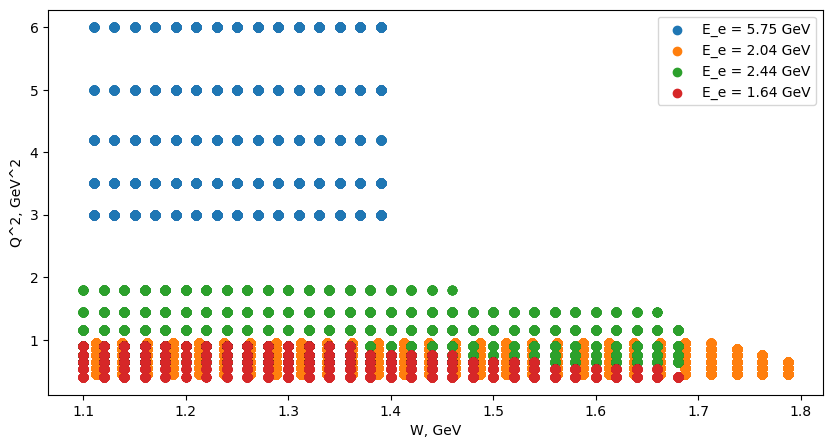

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
class HUBERLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.huber = nn.HuberLoss()

    def forward(self,x,y):
        return self.huber(x,y)

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 20,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 36
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': HUBERLoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            augment_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(augment_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_df = pd.concat([augment_df, aug_df], ignore_index=True)
            train_label_data = augment_df["dsigma_dOmega"]
            train_feature_data = augment_df.loc[:, ~augment_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

In [10]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-11 06:20:40,790 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-11 06:20:40,798 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-11 06:20:40,803 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-11 06:20:40,815 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | HUBERLoss           | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


2024-12-11 06:20:41,745 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | HUBERLoss           | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
2024-12-11 06:20:41,883 : INFO : Training is starting
2024-12-11 06:21:55,827 : INFO : epoch: 0; val_loss: 1.184059739112854
2024-1

INFO: Metric val_loss improved. New best score: 1.184


2024-12-11 06:21:55,930 : INFO : Metric val_loss improved. New best score: 1.184
2024-12-11 06:21:56,510 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=1.18406-epoch=00.ckpt
2024-12-11 06:23:10,316 : INFO : epoch: 1; val_loss: 1.2356810569763184
2024-12-11 06:23:10,336 : INFO : epoch: 1; train_loss: 1.1334152221679688
2024-12-11 06:23:10,702 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=1.23568-epoch=01.ckpt
2024-12-11 06:24:40,661 : INFO : epoch: 2; val_loss: 0.699246883392334
2024-12-11 06:24:40,676 : INFO : epoch: 2; train_loss: 0.8846847414970398


INFO: Metric val_loss improved by 0.485 >= min_delta = 1e-05. New best score: 0.699


2024-12-11 06:24:40,741 : INFO : Metric val_loss improved by 0.485 >= min_delta = 1e-05. New best score: 0.699
2024-12-11 06:24:40,942 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.69925-epoch=02.ckpt
2024-12-11 06:26:19,821 : INFO : epoch: 3; val_loss: 1.1467456817626953
2024-12-11 06:26:19,838 : INFO : epoch: 3; train_loss: 0.602892279624939
2024-12-11 06:26:20,266 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=1.14675-epoch=03.ckpt
2024-12-11 06:27:55,250 : INFO : epoch: 4; val_loss: 0.6713144779205322
2024-12-11 06:27:55,270 : INFO : epoch: 4; train_loss: 0.5570260286331177


INFO: Metric val_loss improved by 0.028 >= min_delta = 1e-05. New best score: 0.671


2024-12-11 06:27:55,352 : INFO : Metric val_loss improved by 0.028 >= min_delta = 1e-05. New best score: 0.671
2024-12-11 06:27:55,762 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.67131-epoch=04.ckpt
2024-12-11 06:29:29,970 : INFO : epoch: 5; val_loss: 0.47655415534973145
2024-12-11 06:29:29,983 : INFO : epoch: 5; train_loss: 0.5259649753570557


INFO: Metric val_loss improved by 0.195 >= min_delta = 1e-05. New best score: 0.477


2024-12-11 06:29:30,059 : INFO : Metric val_loss improved by 0.195 >= min_delta = 1e-05. New best score: 0.477
2024-12-11 06:29:30,258 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.47655-epoch=05.ckpt
2024-12-11 06:31:07,073 : INFO : epoch: 6; val_loss: 0.4758320748806
2024-12-11 06:31:07,094 : INFO : epoch: 6; train_loss: 0.4680626094341278


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.476


2024-12-11 06:31:07,182 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.476
2024-12-11 06:31:07,518 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.47583-epoch=06.ckpt
2024-12-11 06:32:40,844 : INFO : epoch: 7; val_loss: 0.4985000789165497
2024-12-11 06:32:40,858 : INFO : epoch: 7; train_loss: 0.44525909423828125
2024-12-11 06:32:41,113 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.49850-epoch=07.ckpt
2024-12-11 06:34:14,782 : INFO : epoch: 8; val_loss: 0.5117337107658386
2024-12-11 06:34:14,802 : INFO : epoch: 8; train_loss: 0.4256564974784851
2024-12-11 06:35:51,576 : INFO : epoch: 9; val_loss: 0.45173805952072144
2024-12-11 06:35:51,598 : INFO : epoch: 9; train_loss: 0.4204880893230438


INFO: Metric val_loss improved by 0.024 >= min_delta = 1e-05. New best score: 0.452


2024-12-11 06:35:51,715 : INFO : Metric val_loss improved by 0.024 >= min_delta = 1e-05. New best score: 0.452
2024-12-11 06:35:52,049 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.45174-epoch=09.ckpt
2024-12-11 06:37:30,044 : INFO : epoch: 10; val_loss: 0.4497309625148773
2024-12-11 06:37:30,059 : INFO : epoch: 10; train_loss: 0.39892154932022095


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.450


2024-12-11 06:37:30,131 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.450
2024-12-11 06:37:30,464 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.44973-epoch=10.ckpt
2024-12-11 06:39:06,793 : INFO : epoch: 11; val_loss: 0.42485910654067993
2024-12-11 06:39:06,809 : INFO : epoch: 11; train_loss: 0.3953027129173279


INFO: Metric val_loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.425


2024-12-11 06:39:06,879 : INFO : Metric val_loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.425
2024-12-11 06:39:07,147 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.42486-epoch=11.ckpt
2024-12-11 06:40:45,632 : INFO : epoch: 12; val_loss: 0.48757845163345337
2024-12-11 06:40:45,648 : INFO : epoch: 12; train_loss: 0.3930043578147888
2024-12-11 06:42:21,452 : INFO : epoch: 13; val_loss: 0.4641628563404083
2024-12-11 06:42:21,471 : INFO : epoch: 13; train_loss: 0.3921505808830261
2024-12-11 06:43:55,676 : INFO : epoch: 14; val_loss: 0.9887223839759827
2024-12-11 06:43:55,691 : INFO : epoch: 14; train_loss: 0.3800185024738312
2024-12-11 06:45:34,410 : INFO : epoch: 15; val_loss: 0.6123864650726318
2024-12-11 06:45:34,428 : INFO : epoch: 15; train_loss: 0.42013925313949585
2024-12-11 06:47:17,839 : INFO : epoch: 16; val_loss: 0.3988017141819
2024-12-11 06:47:17,855 : INFO : epoch: 16; train_

INFO: Metric val_loss improved by 0.026 >= min_delta = 1e-05. New best score: 0.399


2024-12-11 06:47:17,937 : INFO : Metric val_loss improved by 0.026 >= min_delta = 1e-05. New best score: 0.399
2024-12-11 06:47:18,326 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.39880-epoch=16.ckpt
2024-12-11 06:48:55,835 : INFO : epoch: 17; val_loss: 0.30825603008270264
2024-12-11 06:48:55,850 : INFO : epoch: 17; train_loss: 0.3300708830356598


INFO: Metric val_loss improved by 0.091 >= min_delta = 1e-05. New best score: 0.308


2024-12-11 06:48:55,934 : INFO : Metric val_loss improved by 0.091 >= min_delta = 1e-05. New best score: 0.308
2024-12-11 06:48:56,220 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.30826-epoch=17.ckpt
2024-12-11 06:50:36,175 : INFO : epoch: 18; val_loss: 0.32154154777526855
2024-12-11 06:50:36,191 : INFO : epoch: 18; train_loss: 0.3296965956687927
2024-12-11 06:50:36,383 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.32154-epoch=18.ckpt
2024-12-11 06:52:14,610 : INFO : epoch: 19; val_loss: 0.4454488754272461
2024-12-11 06:52:14,628 : INFO : epoch: 19; train_loss: 0.3311460018157959
2024-12-11 06:53:52,688 : INFO : epoch: 20; val_loss: 0.3346554636955261
2024-12-11 06:53:52,707 : INFO : epoch: 20; train_loss: 0.33827728033065796
2024-12-11 06:53:53,182 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, u

INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.304


2024-12-11 06:57:18,086 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.304
2024-12-11 06:57:18,518 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.30401-epoch=22.ckpt
2024-12-11 06:58:56,808 : INFO : epoch: 23; val_loss: 0.32799476385116577
2024-12-11 06:58:56,826 : INFO : epoch: 23; train_loss: 0.32915693521499634
2024-12-11 07:00:37,554 : INFO : epoch: 24; val_loss: 0.3010311722755432
2024-12-11 07:00:37,569 : INFO : epoch: 24; train_loss: 0.32297399640083313


INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.301


2024-12-11 07:00:37,643 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.301
2024-12-11 07:00:37,949 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.30103-epoch=24.ckpt
2024-12-11 07:02:15,356 : INFO : epoch: 25; val_loss: 0.3026771545410156
2024-12-11 07:02:15,371 : INFO : epoch: 25; train_loss: 0.3235296905040741
2024-12-11 07:02:15,669 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.30268-epoch=25.ckpt
2024-12-11 07:03:54,179 : INFO : epoch: 26; val_loss: 0.37017977237701416
2024-12-11 07:03:54,194 : INFO : epoch: 26; train_loss: 0.3186057209968567
2024-12-11 07:05:32,140 : INFO : epoch: 27; val_loss: 0.2874343693256378
2024-12-11 07:05:32,158 : INFO : epoch: 27; train_loss: 0.32119205594062805


INFO: Metric val_loss improved by 0.014 >= min_delta = 1e-05. New best score: 0.287


2024-12-11 07:05:32,254 : INFO : Metric val_loss improved by 0.014 >= min_delta = 1e-05. New best score: 0.287
2024-12-11 07:05:32,572 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.28743-epoch=27.ckpt
2024-12-11 07:07:11,987 : INFO : epoch: 28; val_loss: 0.6101426482200623
2024-12-11 07:07:12,004 : INFO : epoch: 28; train_loss: 0.3274632692337036
2024-12-11 07:08:49,392 : INFO : epoch: 29; val_loss: 0.3642366826534271
2024-12-11 07:08:49,411 : INFO : epoch: 29; train_loss: 0.3620266020298004
2024-12-11 07:10:30,145 : INFO : epoch: 30; val_loss: 0.32939356565475464
2024-12-11 07:10:30,164 : INFO : epoch: 30; train_loss: 0.318086177110672
2024-12-11 07:12:19,467 : INFO : epoch: 31; val_loss: 0.33376824855804443
2024-12-11 07:12:19,491 : INFO : epoch: 31; train_loss: 0.31770965456962585
2024-12-11 07:14:00,272 : INFO : epoch: 32; val_loss: 0.4168560206890106
2024-12-11 07:14:00,292 : INFO : epoch: 32; tra

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.286


2024-12-11 07:15:41,601 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.286
2024-12-11 07:15:41,850 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.28649-epoch=33.ckpt
2024-12-11 07:17:23,651 : INFO : epoch: 34; val_loss: 0.2855628430843353
2024-12-11 07:17:23,667 : INFO : epoch: 34; train_loss: 0.29087281227111816


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.286


2024-12-11 07:17:23,741 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.286
2024-12-11 07:17:23,984 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.28556-epoch=34.ckpt
2024-12-11 07:19:03,166 : INFO : epoch: 35; val_loss: 0.30800437927246094
2024-12-11 07:19:03,183 : INFO : epoch: 35; train_loss: 0.28892600536346436
2024-12-11 07:20:42,822 : INFO : epoch: 36; val_loss: 0.30641621351242065
2024-12-11 07:20:42,839 : INFO : epoch: 36; train_loss: 0.29165908694267273
2024-12-11 07:22:21,831 : INFO : epoch: 37; val_loss: 0.2828845977783203
2024-12-11 07:22:21,851 : INFO : epoch: 37; train_loss: 0.28950247168540955


INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.283


2024-12-11 07:22:21,944 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.283
2024-12-11 07:22:22,234 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.28288-epoch=37.ckpt
2024-12-11 07:24:00,962 : INFO : epoch: 38; val_loss: 0.27541583776474
2024-12-11 07:24:00,977 : INFO : epoch: 38; train_loss: 0.2851719558238983


INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.275


2024-12-11 07:24:01,053 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.275
2024-12-11 07:24:01,282 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.27542-epoch=38.ckpt
2024-12-11 07:25:40,599 : INFO : epoch: 39; val_loss: 0.2733076214790344
2024-12-11 07:25:40,614 : INFO : epoch: 39; train_loss: 0.2898874878883362


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.273


2024-12-11 07:25:40,685 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.273
2024-12-11 07:25:40,916 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.27331-epoch=39.ckpt
2024-12-11 07:27:32,061 : INFO : epoch: 40; val_loss: 0.2932508587837219
2024-12-11 07:27:32,080 : INFO : epoch: 40; train_loss: 0.2898707091808319
2024-12-11 07:29:18,110 : INFO : epoch: 41; val_loss: 0.333448588848114
2024-12-11 07:29:18,128 : INFO : epoch: 41; train_loss: 0.29323524236679077
2024-12-11 07:31:03,463 : INFO : epoch: 42; val_loss: 0.2883903980255127
2024-12-11 07:31:03,481 : INFO : epoch: 42; train_loss: 0.293052077293396
2024-12-11 07:32:51,217 : INFO : epoch: 43; val_loss: 0.28804972767829895
2024-12-11 07:32:51,233 : INFO : epoch: 43; train_loss: 0.2854556143283844
2024-12-11 07:34:35,185 : INFO : epoch: 44; val_loss: 0.3140089511871338
2024-12-11 07:34:35,202 : INFO : epoch: 44; train

INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.267


2024-12-11 07:46:36,118 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.267
2024-12-11 07:46:36,336 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26744-epoch=51.ckpt
2024-12-11 07:48:16,699 : INFO : epoch: 52; val_loss: 0.2666751444339752
2024-12-11 07:48:16,714 : INFO : epoch: 52; train_loss: 0.272238552570343


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.267


2024-12-11 07:48:16,791 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.267
2024-12-11 07:48:17,063 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26668-epoch=52.ckpt
2024-12-11 07:49:56,484 : INFO : epoch: 53; val_loss: 0.27131736278533936
2024-12-11 07:49:56,500 : INFO : epoch: 53; train_loss: 0.2740631401538849
2024-12-11 07:49:56,812 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.27132-epoch=53.ckpt
2024-12-11 07:51:39,740 : INFO : epoch: 54; val_loss: 0.2813848853111267
2024-12-11 07:51:39,755 : INFO : epoch: 54; train_loss: 0.2712554931640625
2024-12-11 07:53:19,009 : INFO : epoch: 55; val_loss: 0.2721054255962372
2024-12-11 07:53:19,024 : INFO : epoch: 55; train_loss: 0.2747358977794647
2024-12-11 07:54:58,745 : INFO : epoch: 56; val_loss: 0.2684914171695709
2024-12-11 07:54:58,7

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.266


2024-12-11 08:20:22,660 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.266
2024-12-11 08:20:22,973 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26582-epoch=71.ckpt
2024-12-11 08:22:05,963 : INFO : epoch: 72; val_loss: 0.2672766149044037
2024-12-11 08:22:05,982 : INFO : epoch: 72; train_loss: 0.26384061574935913
2024-12-11 08:22:06,411 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26728-epoch=72.ckpt
2024-12-11 08:23:47,855 : INFO : epoch: 73; val_loss: 0.2679036259651184
2024-12-11 08:23:47,870 : INFO : epoch: 73; train_loss: 0.2673942744731903
2024-12-11 08:25:28,544 : INFO : epoch: 74; val_loss: 0.2650217115879059
2024-12-11 08:25:28,560 : INFO : epoch: 74; train_loss: 0.2656172215938568


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.265


2024-12-11 08:25:28,644 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.265
2024-12-11 08:25:28,893 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26502-epoch=74.ckpt
2024-12-11 08:27:12,554 : INFO : epoch: 75; val_loss: 0.2636553943157196
2024-12-11 08:27:12,571 : INFO : epoch: 75; train_loss: 0.26445820927619934


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.264


2024-12-11 08:27:12,647 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.264
2024-12-11 08:27:12,887 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26366-epoch=75.ckpt
2024-12-11 08:28:53,921 : INFO : epoch: 76; val_loss: 0.26615476608276367
2024-12-11 08:28:53,939 : INFO : epoch: 76; train_loss: 0.2637473940849304
2024-12-11 08:30:35,627 : INFO : epoch: 77; val_loss: 0.2656344473361969
2024-12-11 08:30:35,651 : INFO : epoch: 77; train_loss: 0.26445144414901733
2024-12-11 08:30:36,083 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26563-epoch=77.ckpt
2024-12-11 08:32:23,056 : INFO : epoch: 78; val_loss: 0.26483404636383057
2024-12-11 08:32:23,082 : INFO : epoch: 78; train_loss: 0.26517370343208313
2024-12-11 08:32:23,540 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0,

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263


2024-12-11 08:44:19,919 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263
2024-12-11 08:44:20,109 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26328-epoch=85.ckpt
2024-12-11 08:46:02,640 : INFO : epoch: 86; val_loss: 0.26410242915153503
2024-12-11 08:46:02,655 : INFO : epoch: 86; train_loss: 0.26021450757980347
2024-12-11 08:46:02,961 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26410-epoch=86.ckpt
2024-12-11 08:47:49,504 : INFO : epoch: 87; val_loss: 0.268998920917511
2024-12-11 08:47:49,522 : INFO : epoch: 87; train_loss: 0.26109880208969116
2024-12-11 08:49:34,246 : INFO : epoch: 88; val_loss: 0.2635585069656372
2024-12-11 08:49:34,266 : INFO : epoch: 88; train_loss: 0.26250240206718445
2024-12-11 08:49:34,654 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, 

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263


2024-12-11 09:07:25,855 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263
2024-12-11 09:07:26,053 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26298-epoch=98.ckpt
2024-12-11 09:09:13,284 : INFO : epoch: 99; val_loss: 0.2649717628955841
2024-12-11 09:09:13,301 : INFO : epoch: 99; train_loss: 0.2594280242919922
2024-12-11 09:11:02,513 : INFO : epoch: 100; val_loss: 0.26573678851127625
2024-12-11 09:11:02,538 : INFO : epoch: 100; train_loss: 0.25917690992355347
2024-12-11 09:12:53,719 : INFO : epoch: 101; val_loss: 0.2625582814216614
2024-12-11 09:12:53,735 : INFO : epoch: 101; train_loss: 0.2593163847923279


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263


2024-12-11 09:12:53,817 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.263
2024-12-11 09:12:54,081 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26256-epoch=101.ckpt
2024-12-11 09:14:42,066 : INFO : epoch: 102; val_loss: 0.2625795602798462
2024-12-11 09:14:42,081 : INFO : epoch: 102; train_loss: 0.2578834593296051
2024-12-11 09:14:42,426 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26258-epoch=102.ckpt
2024-12-11 09:16:31,180 : INFO : epoch: 103; val_loss: 0.26245322823524475
2024-12-11 09:16:31,201 : INFO : epoch: 103; train_loss: 0.2570990324020386


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262


2024-12-11 09:16:31,298 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262
2024-12-11 09:16:31,696 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26245-epoch=103.ckpt
2024-12-11 09:18:22,850 : INFO : epoch: 104; val_loss: 0.26253175735473633
2024-12-11 09:18:22,869 : INFO : epoch: 104; train_loss: 0.25741925835609436
2024-12-11 09:18:23,216 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26253-epoch=104.ckpt
2024-12-11 09:20:14,552 : INFO : epoch: 105; val_loss: 0.2638627290725708
2024-12-11 09:20:14,567 : INFO : epoch: 105; train_loss: 0.2578216791152954
2024-12-11 09:22:05,340 : INFO : epoch: 106; val_loss: 0.26445916295051575
2024-12-11 09:22:05,361 : INFO : epoch: 106; train_loss: 0.2577023208141327
2024-12-11 09:23:58,356 : INFO : epoch: 107; val_loss: 0.2632443904876709
2024-12-11

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262


2024-12-11 09:29:29,532 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262
2024-12-11 09:29:29,725 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26212-epoch=110.ckpt
2024-12-11 09:31:22,472 : INFO : epoch: 111; val_loss: 0.2636348605155945
2024-12-11 09:31:22,488 : INFO : epoch: 111; train_loss: 0.2590949535369873
2024-12-11 09:33:14,573 : INFO : epoch: 112; val_loss: 0.26484060287475586
2024-12-11 09:33:14,587 : INFO : epoch: 112; train_loss: 0.2569340765476227
2024-12-11 09:35:08,301 : INFO : epoch: 113; val_loss: 0.26287269592285156
2024-12-11 09:35:08,318 : INFO : epoch: 113; train_loss: 0.257018119096756
2024-12-11 09:37:02,925 : INFO : epoch: 114; val_loss: 0.2624483108520508
2024-12-11 09:37:02,940 : INFO : epoch: 114; train_loss: 0.2582925856113434
2024-12-11 09:37:03,222 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/swe

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262


2024-12-11 09:42:52,436 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262
2024-12-11 09:42:52,660 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26198-epoch=117.ckpt
2024-12-11 09:44:44,079 : INFO : epoch: 118; val_loss: 0.2615048587322235
2024-12-11 09:44:44,098 : INFO : epoch: 118; train_loss: 0.2573680281639099


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262


2024-12-11 09:44:44,190 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.262
2024-12-11 09:44:44,502 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26150-epoch=118.ckpt
2024-12-11 09:46:37,724 : INFO : epoch: 119; val_loss: 0.2617485523223877
2024-12-11 09:46:37,739 : INFO : epoch: 119; train_loss: 0.257175087928772
2024-12-11 09:46:38,020 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/sweet-dew-18/checkpoints/exp_name=0val_loss=0.26175-epoch=119.ckpt
2024-12-11 09:48:32,522 : INFO : epoch: 120; val_loss: 0.2626536786556244
2024-12-11 09:48:32,538 : INFO : epoch: 120; train_loss: 0.2557262182235718
2024-12-11 09:50:23,916 : INFO : epoch: 121; val_loss: 0.2622111737728119
2024-12-11 09:50:23,938 : INFO : epoch: 121; train_loss: 0.25637465715408325
2024-12-11 09:52:21,215 : INFO : epoch: 122; val_loss: 0.2620849609375
2024-12-11 09:52

INFO: Monitored metric val_loss did not improve in the last 20 records. Best score: 0.262. Signaling Trainer to stop.


2024-12-11 10:23:14,319 : INFO : Monitored metric val_loss did not improve in the last 20 records. Best score: 0.262. Signaling Trainer to stop.
2024-12-11 10:23:14,335 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [11]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [12]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:06<00:00, 24.37it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2015179581902993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008966432049494702' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-11 10:37:04,133 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-11 10:37:04,137 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2024-12-11 10:37:04,141 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-11 10:37:04,145 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-11 10:37:04,149 : DEBUG : findfont: score(FontEntry(f

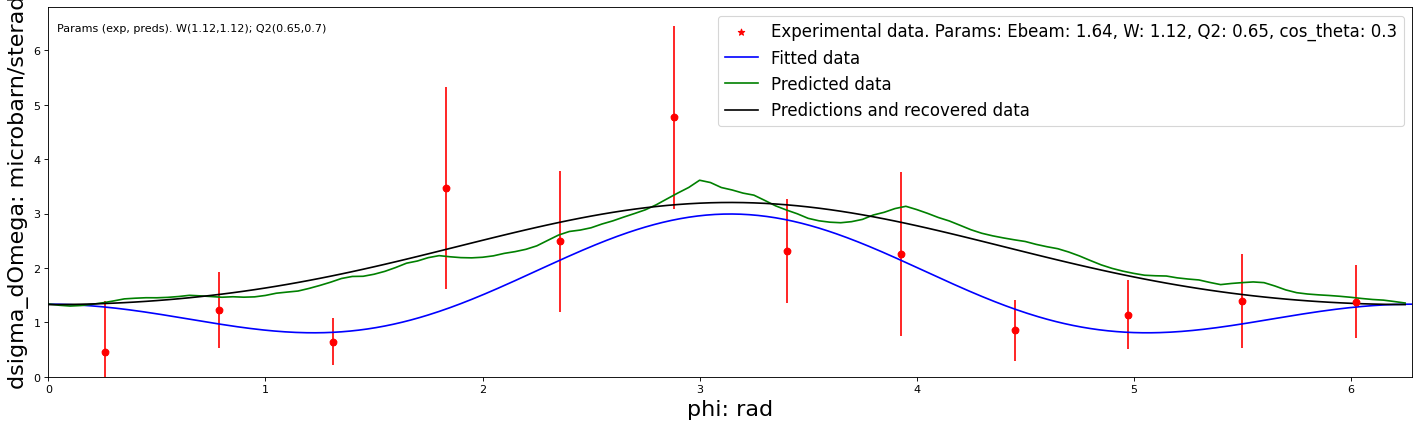

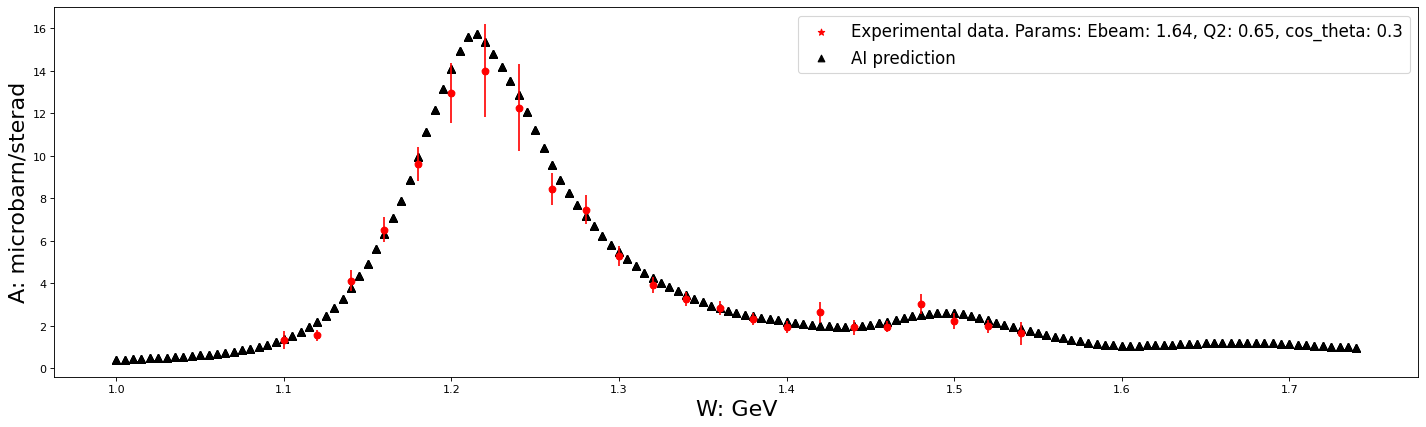

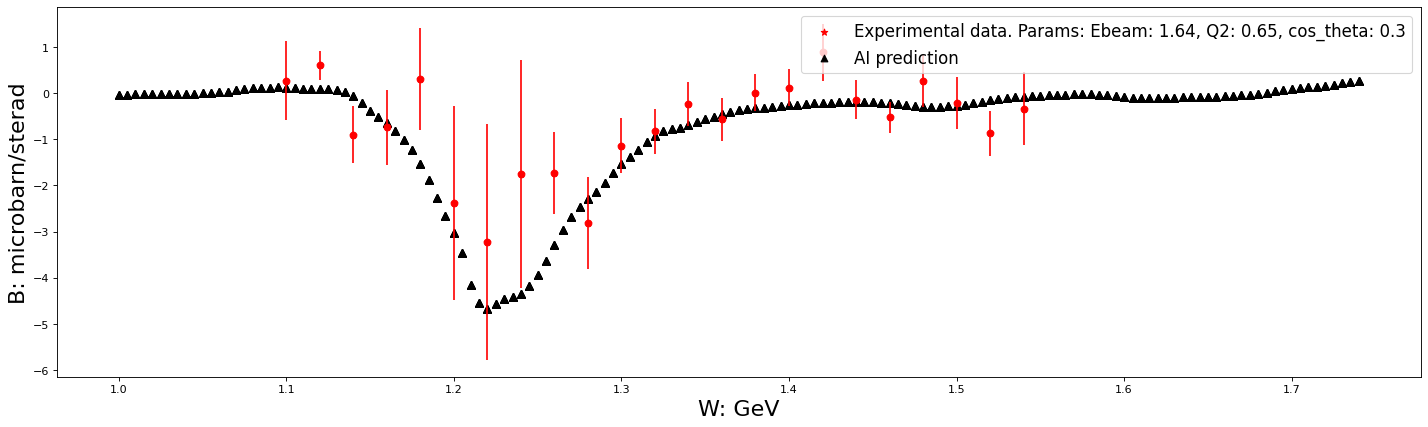

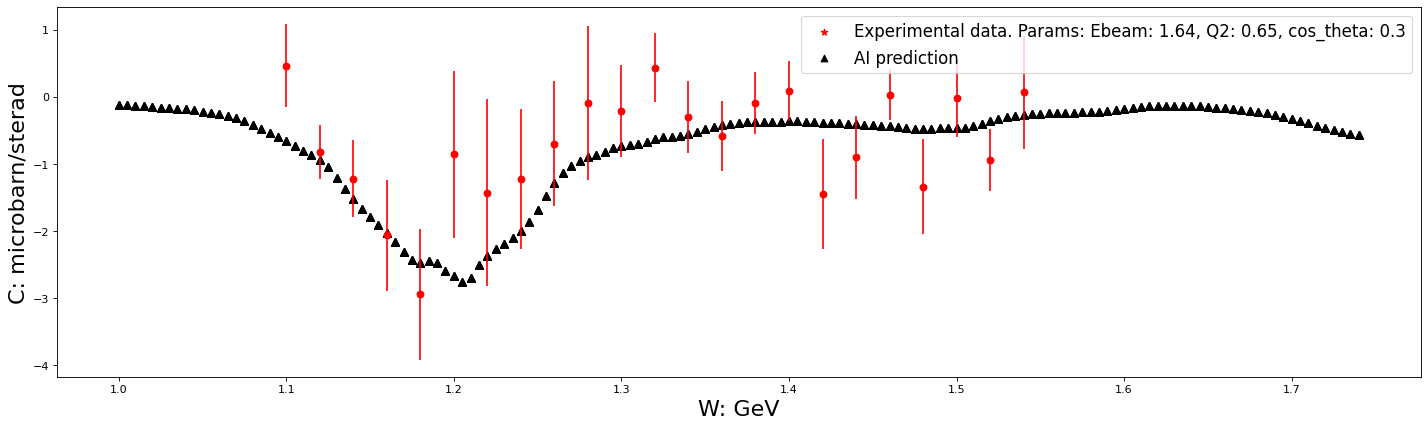

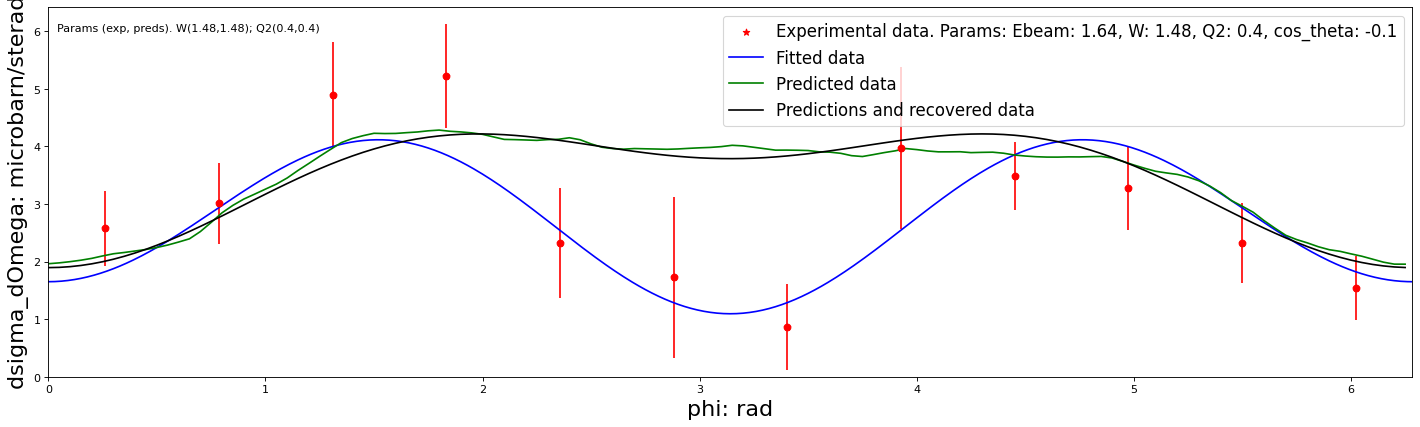

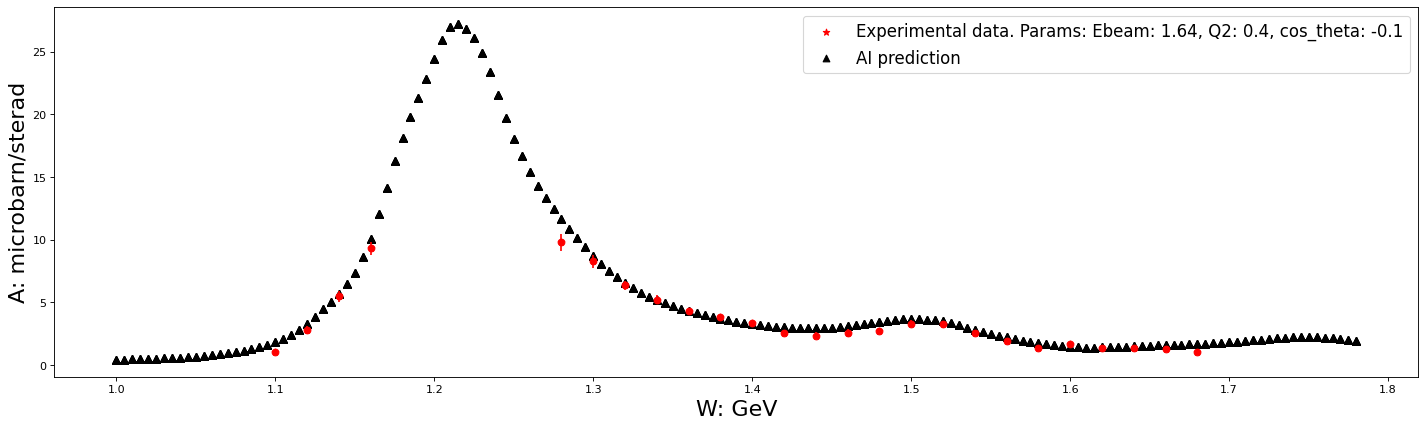

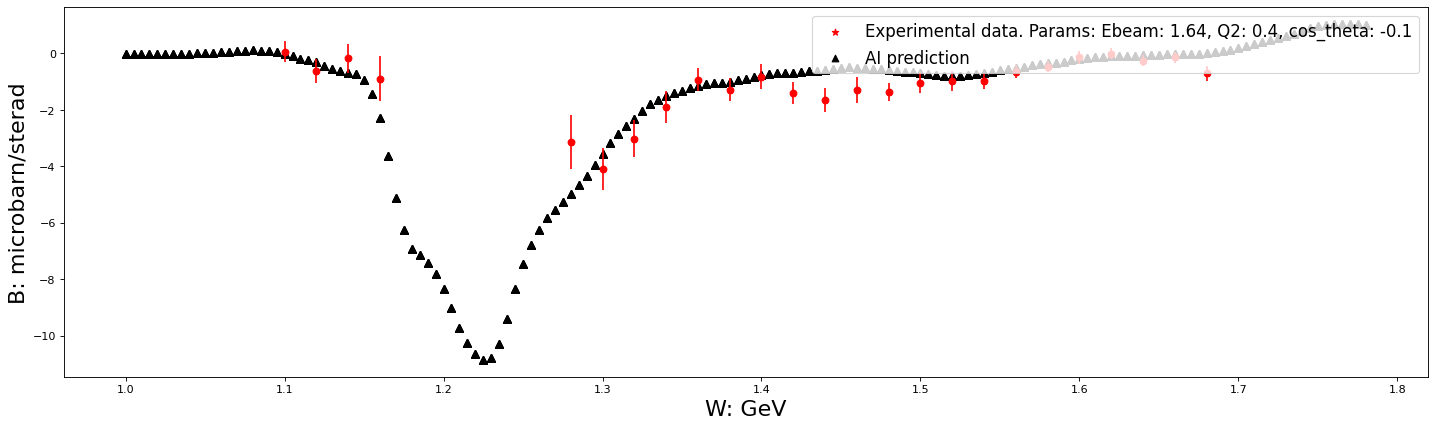

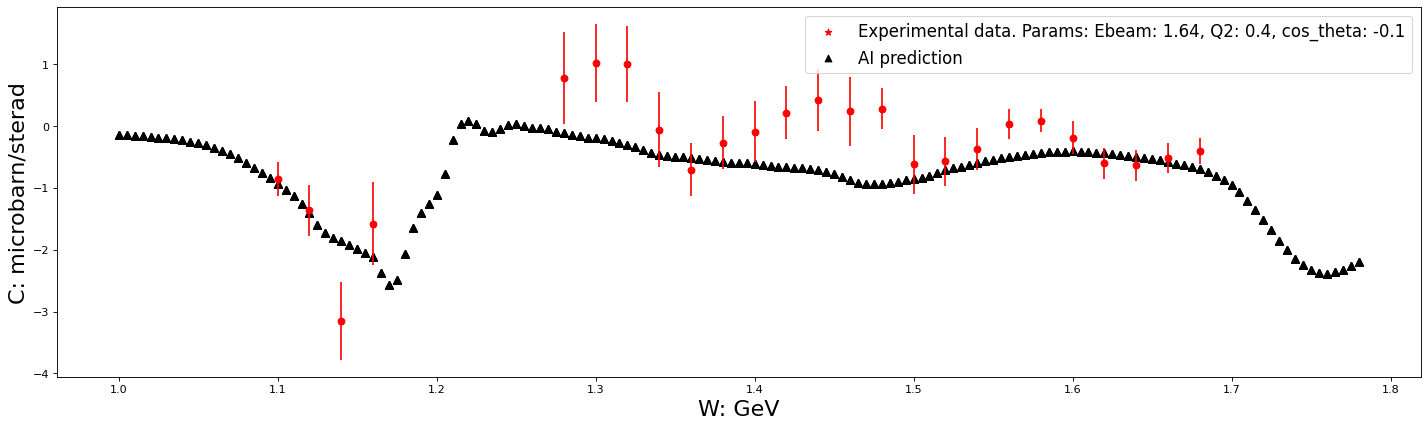

100%|██████████| 157/157 [00:08<00:00, 19.30it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13592952989268858' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0018526188288520847' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-

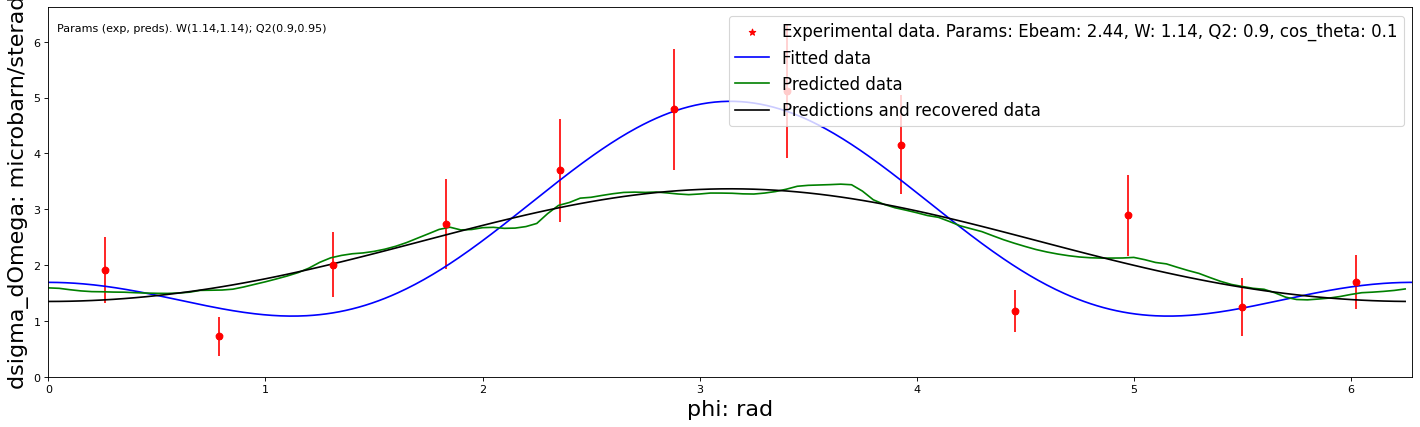

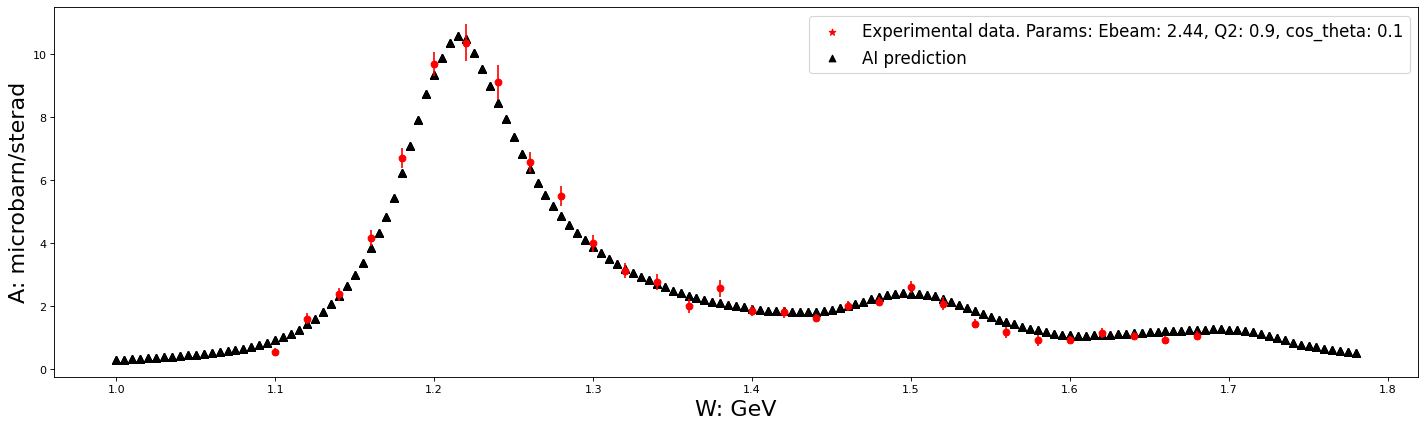

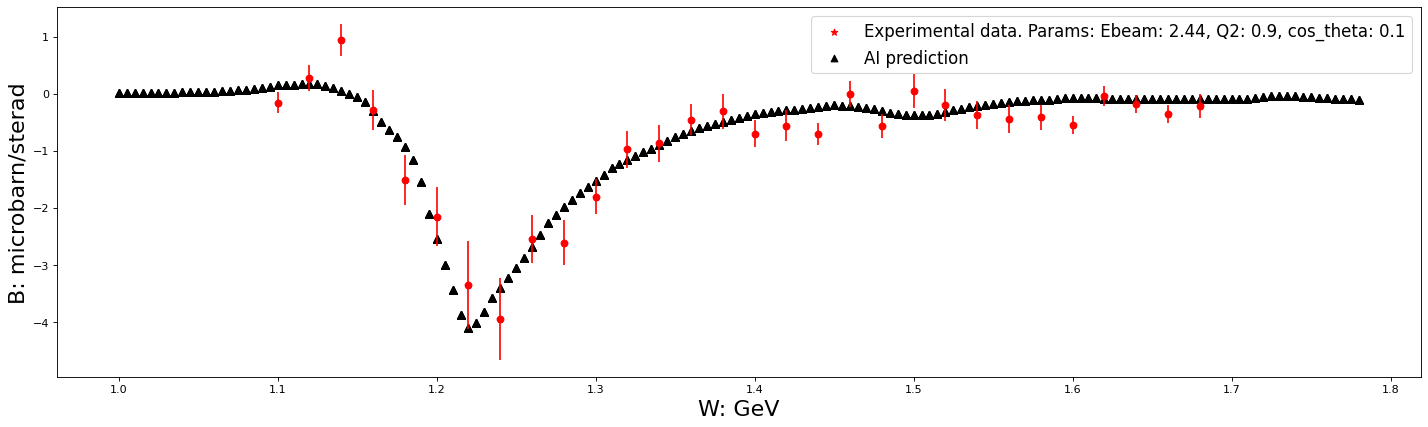

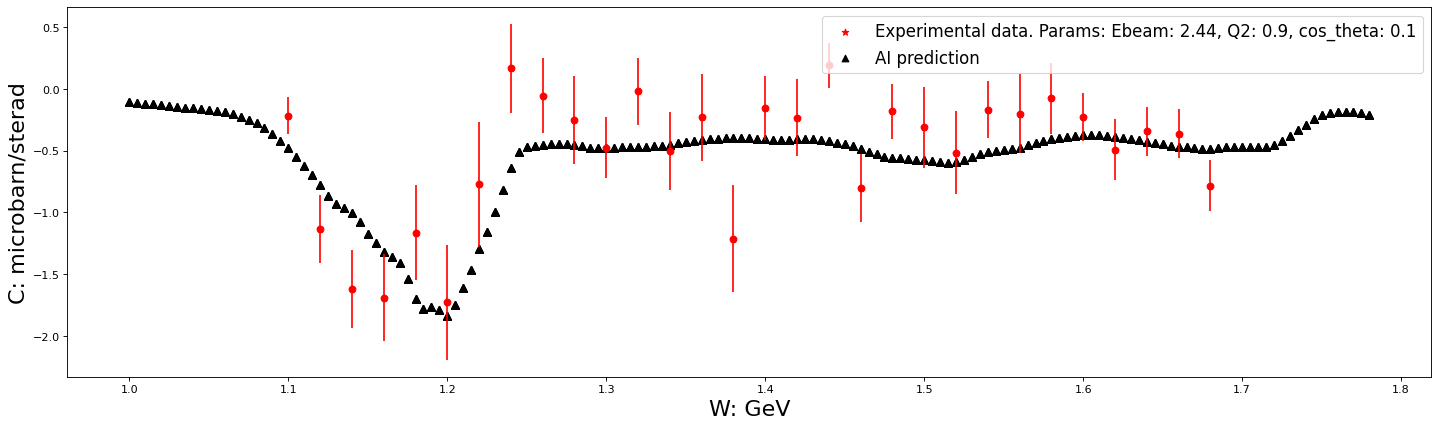

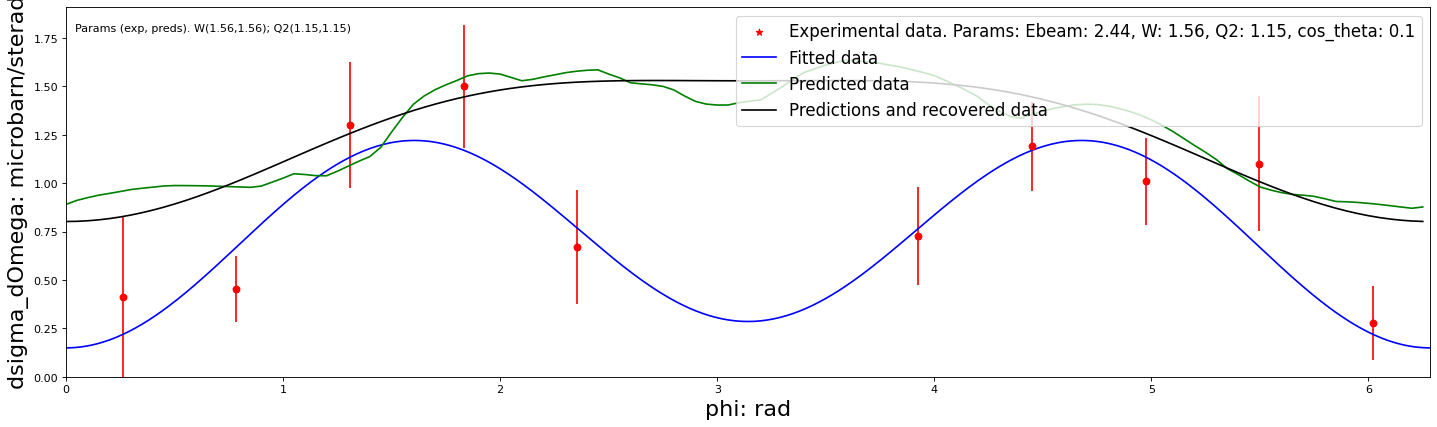

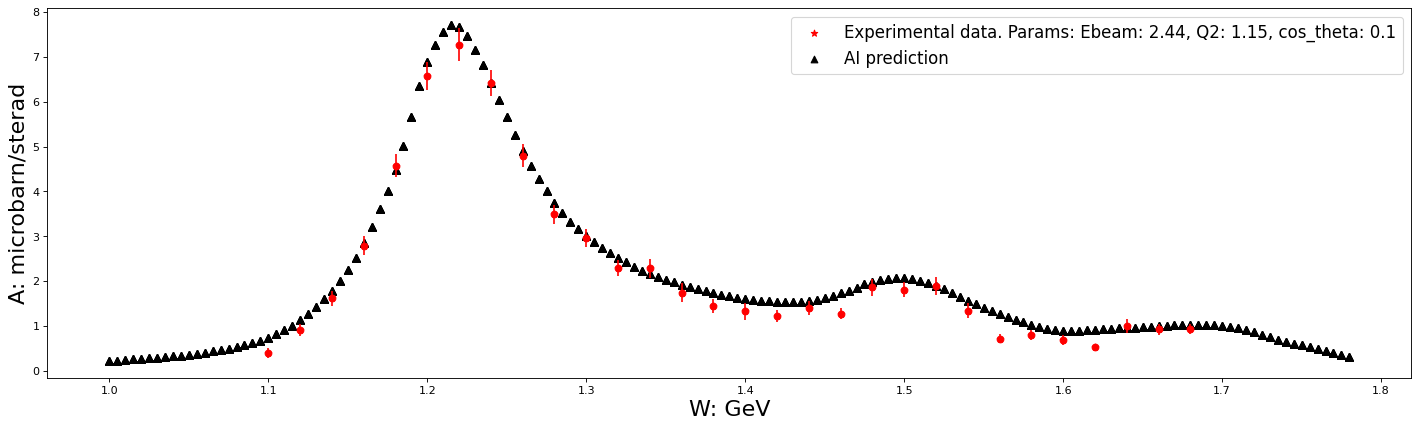

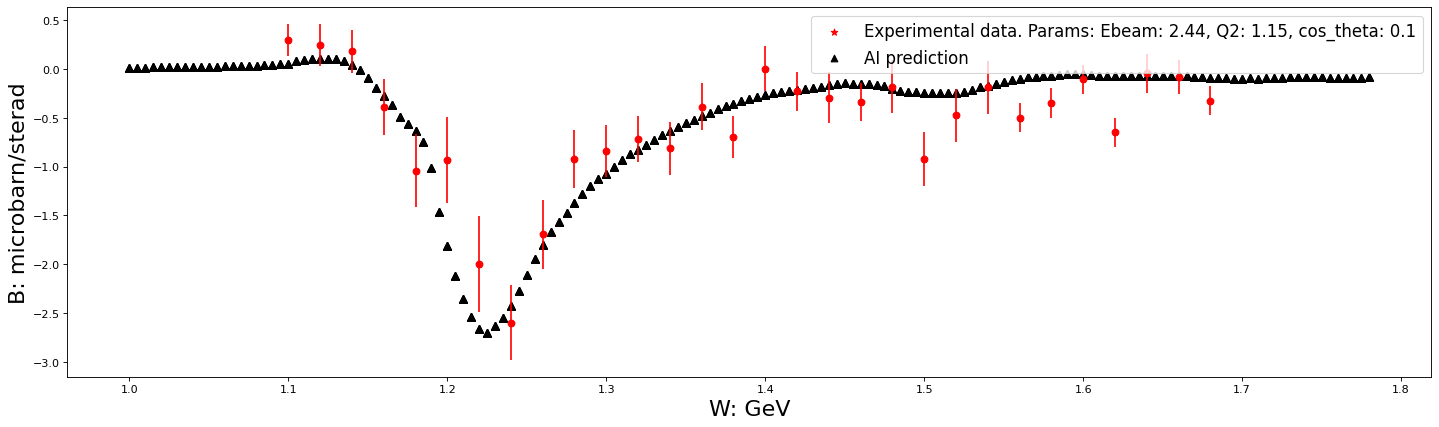

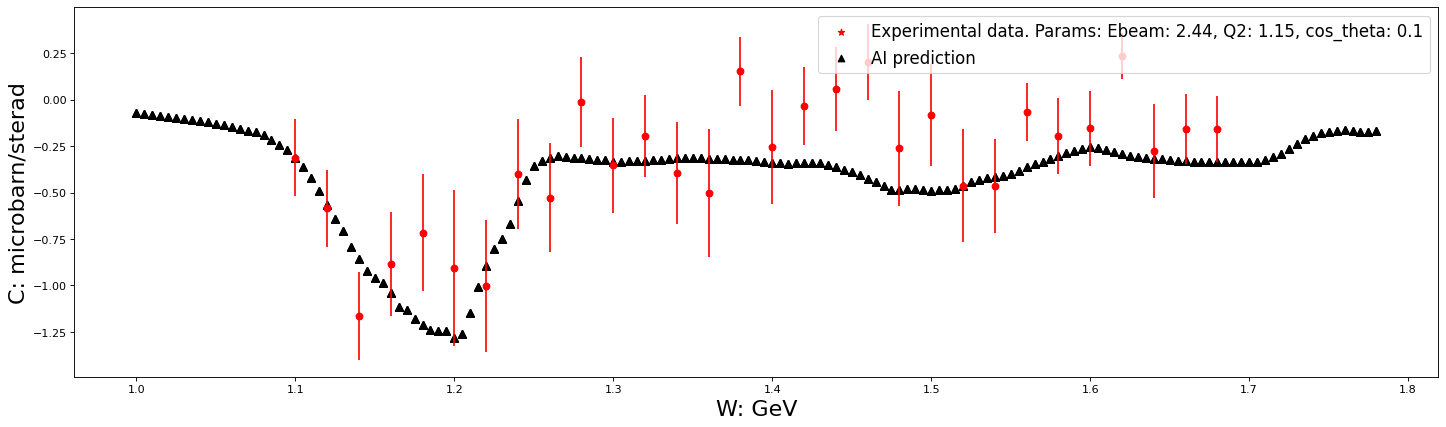

100%|██████████| 97/97 [00:10<00:00,  9.23it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.03766367182311246' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0044267284232799185' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

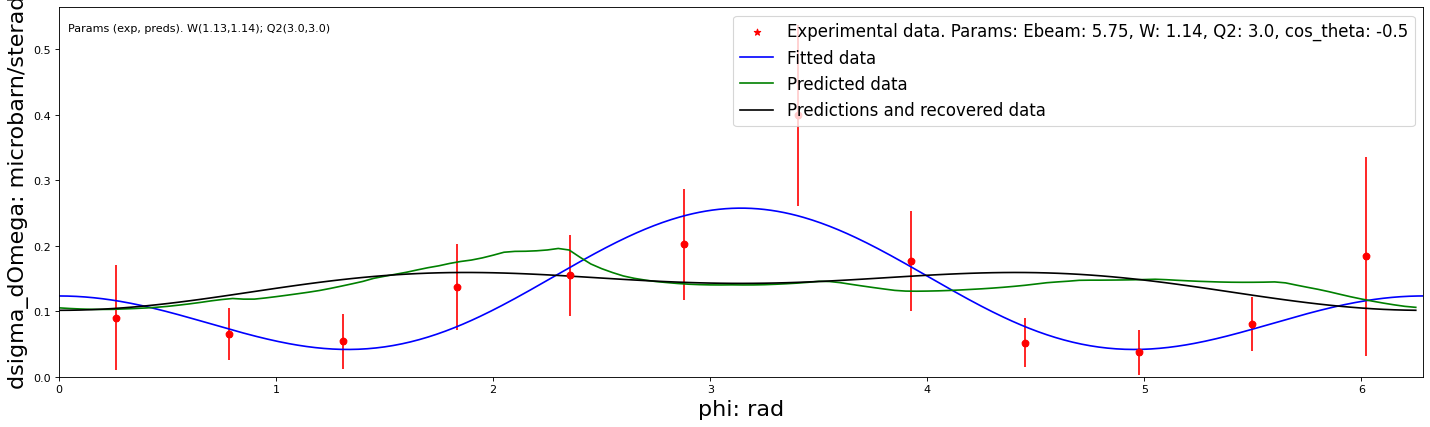

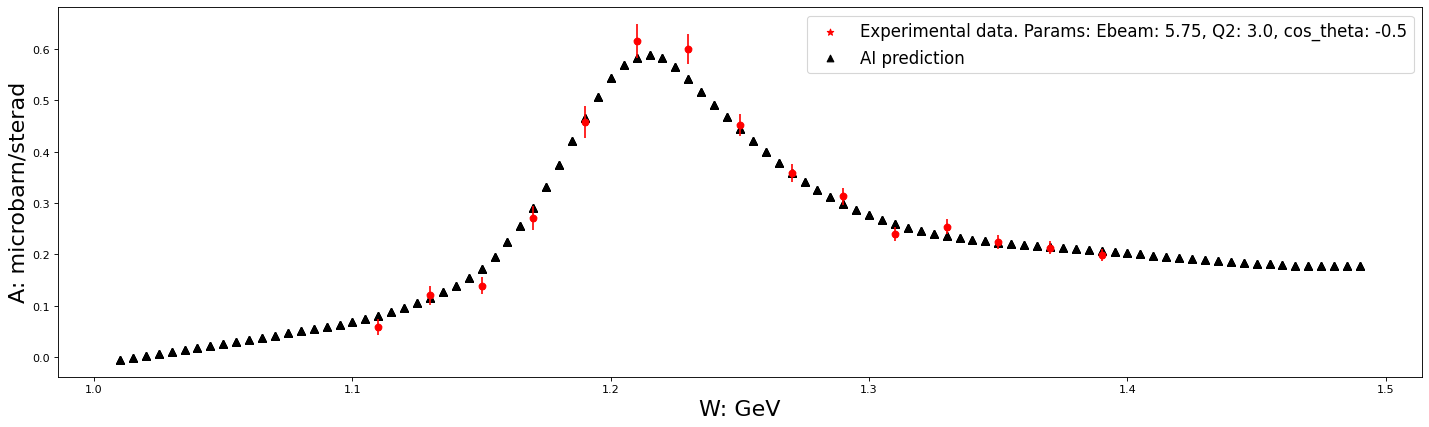

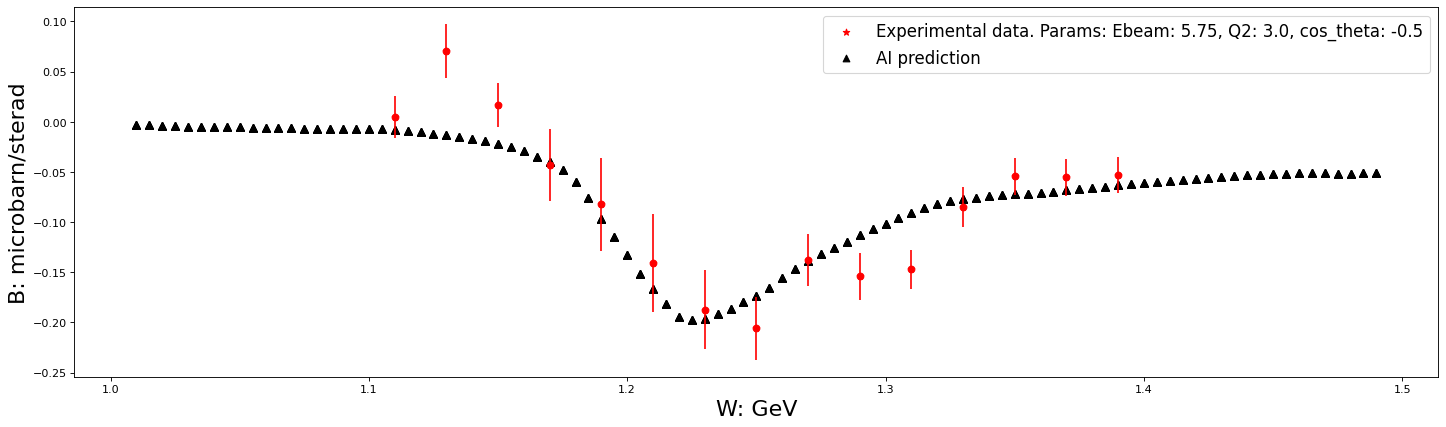

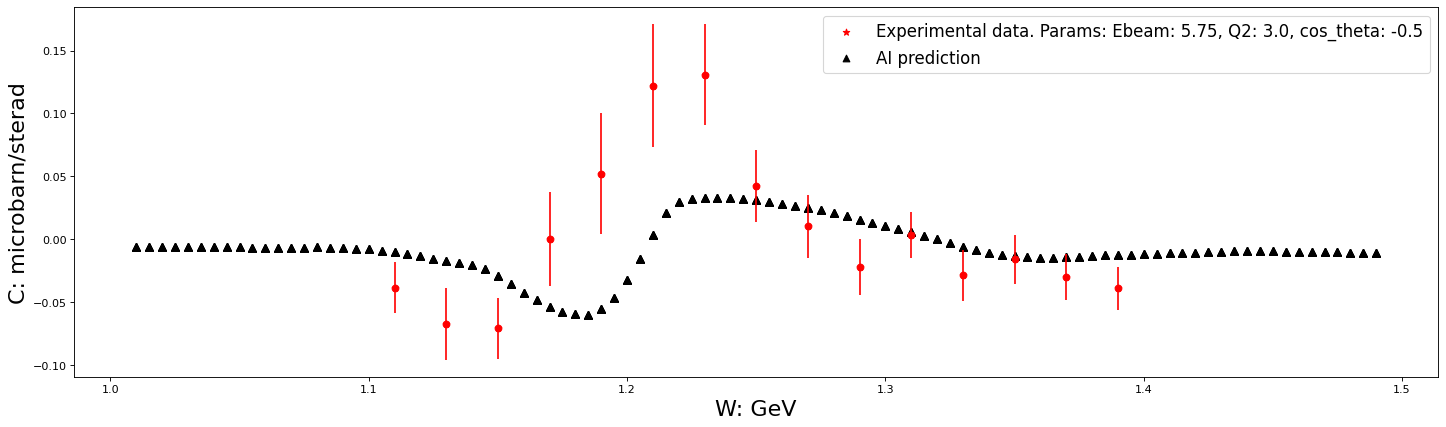

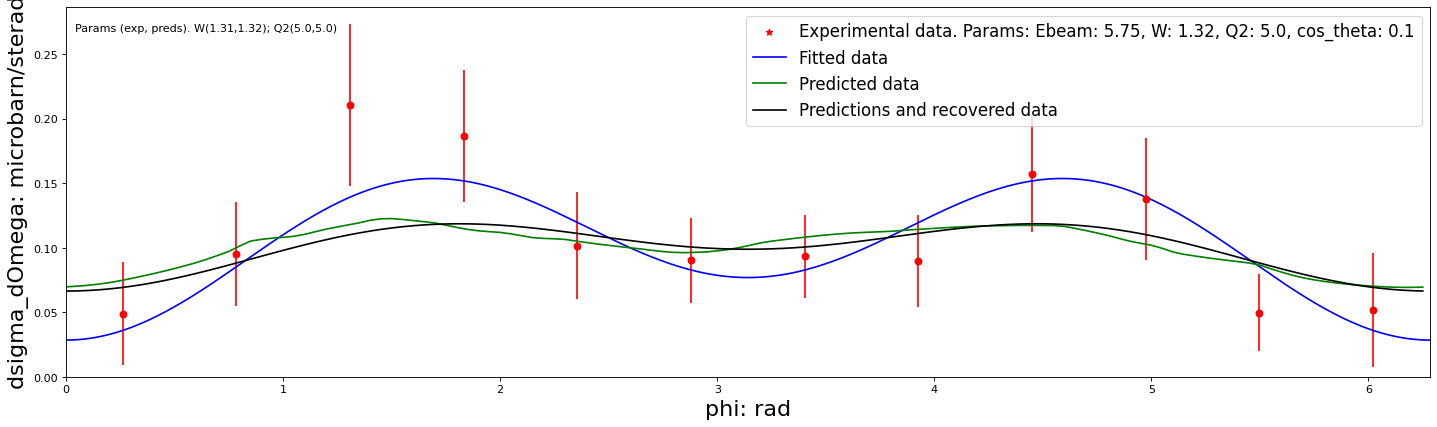

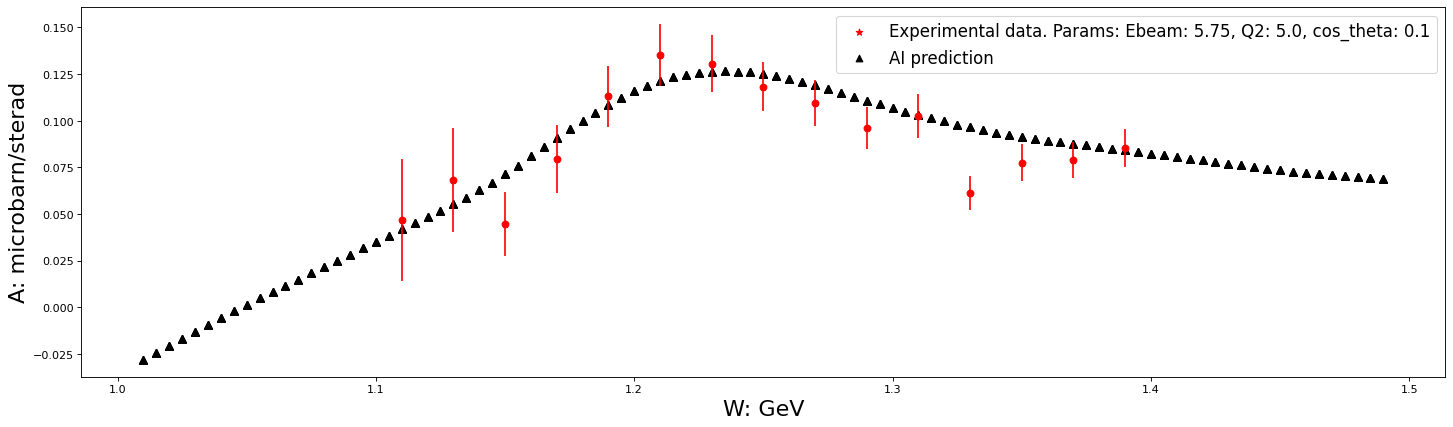

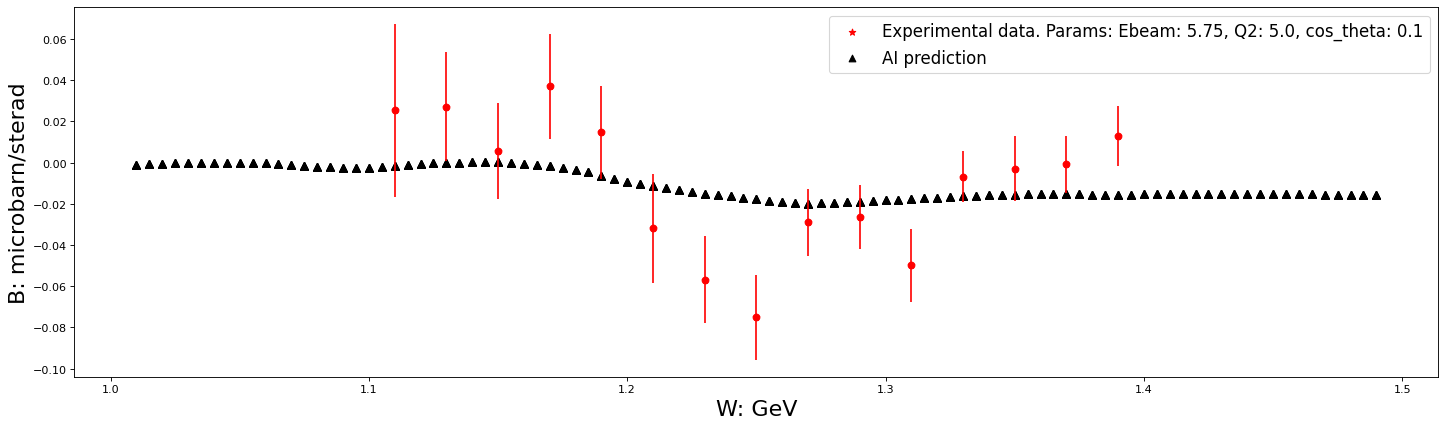

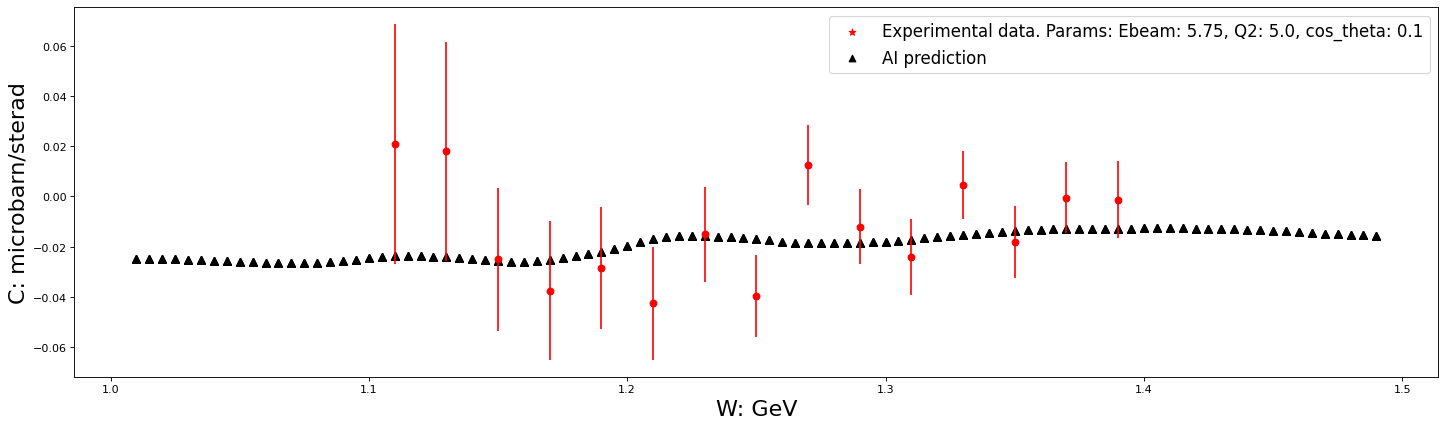

100%|██████████| 177/177 [00:05<00:00, 32.55it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15693178292167312' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008713218482543689' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

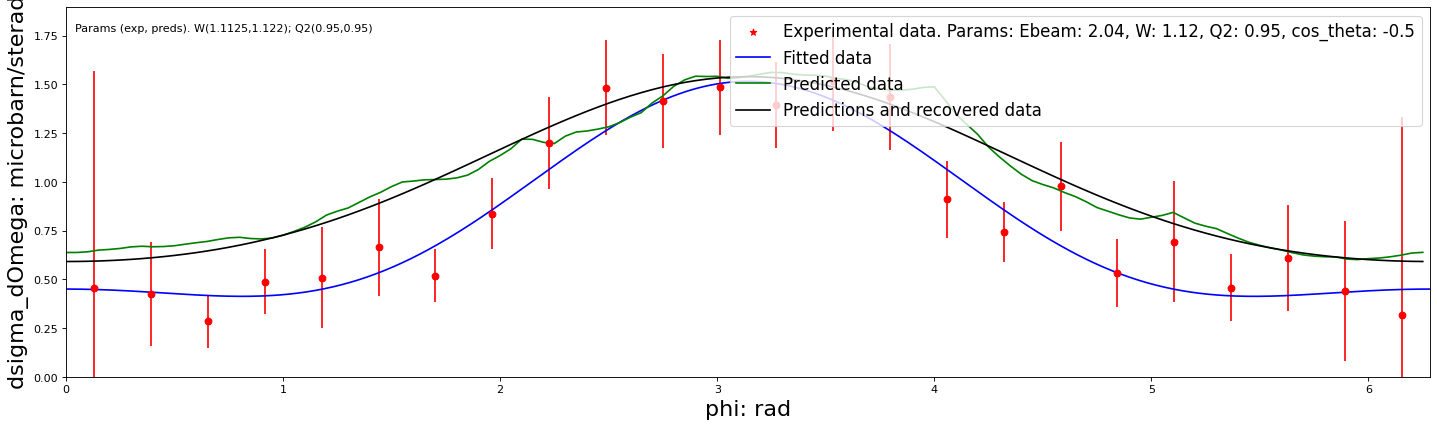

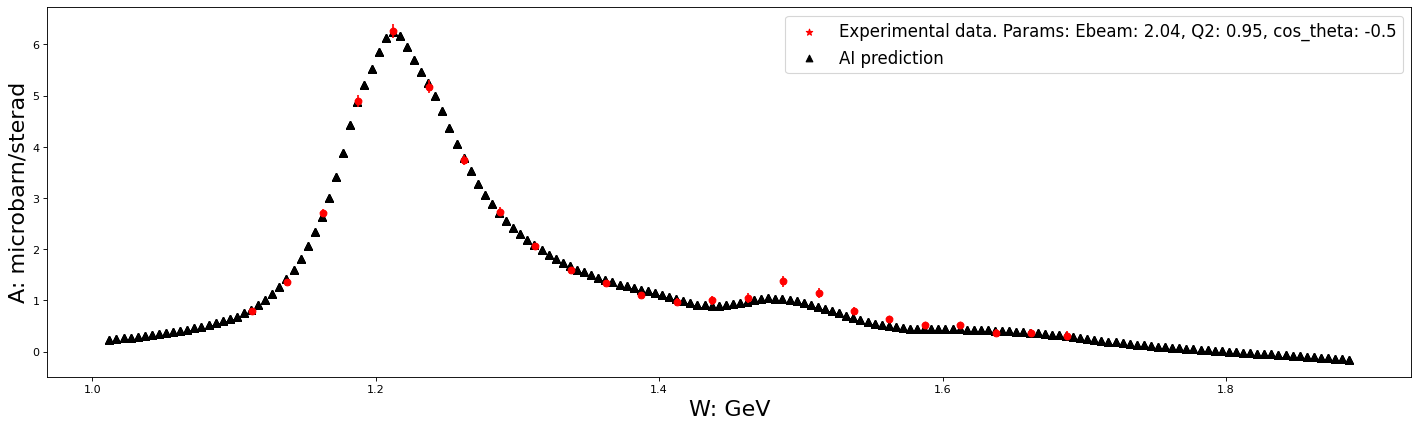

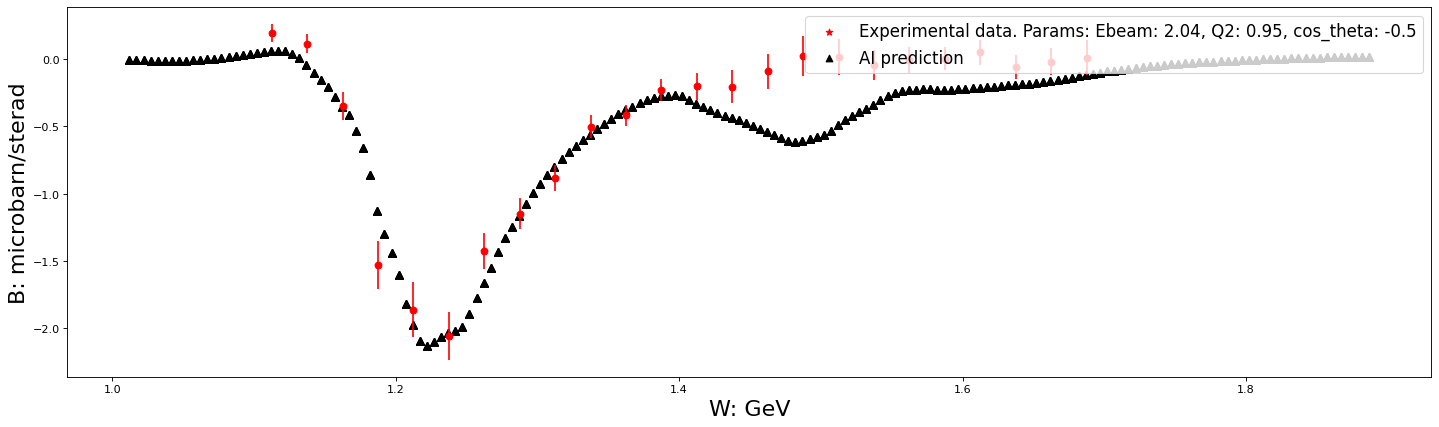

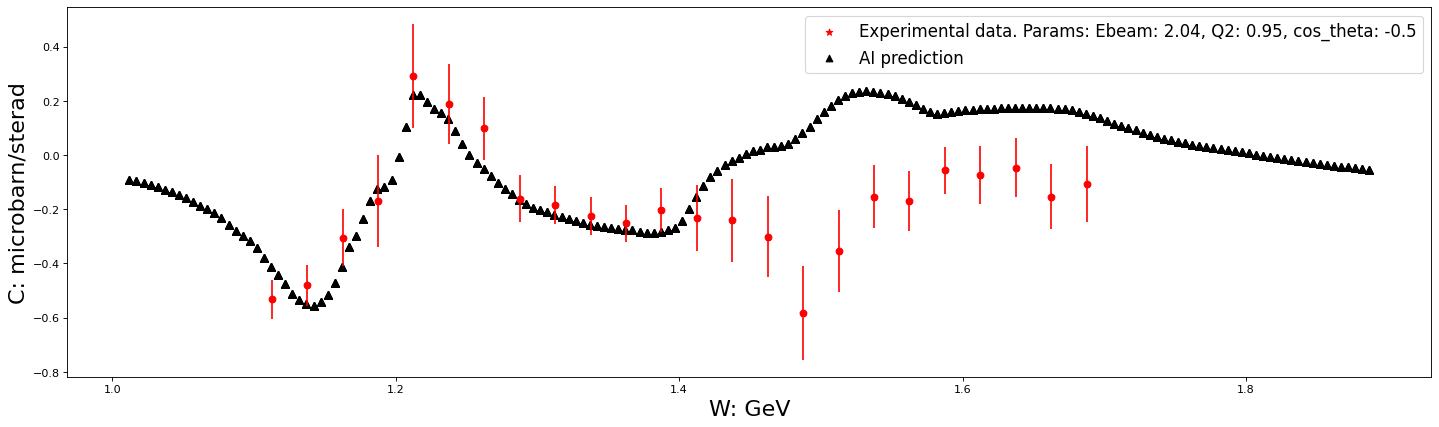

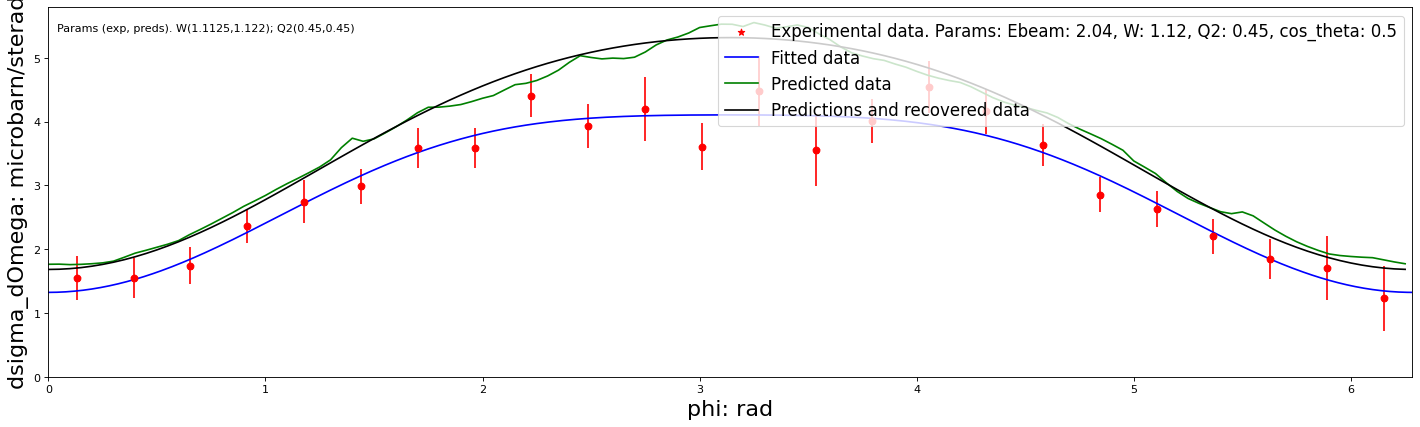

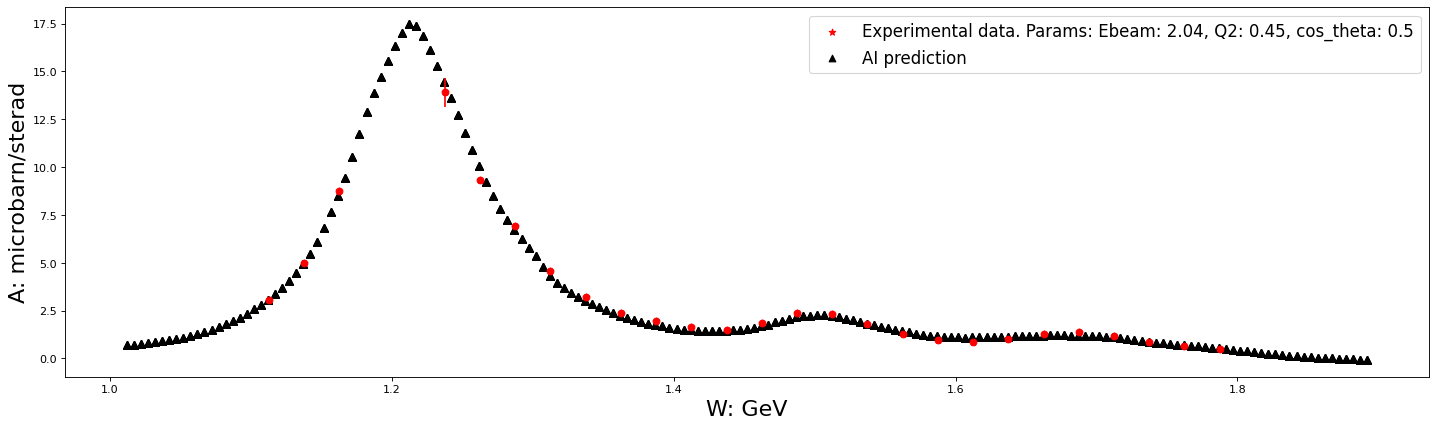

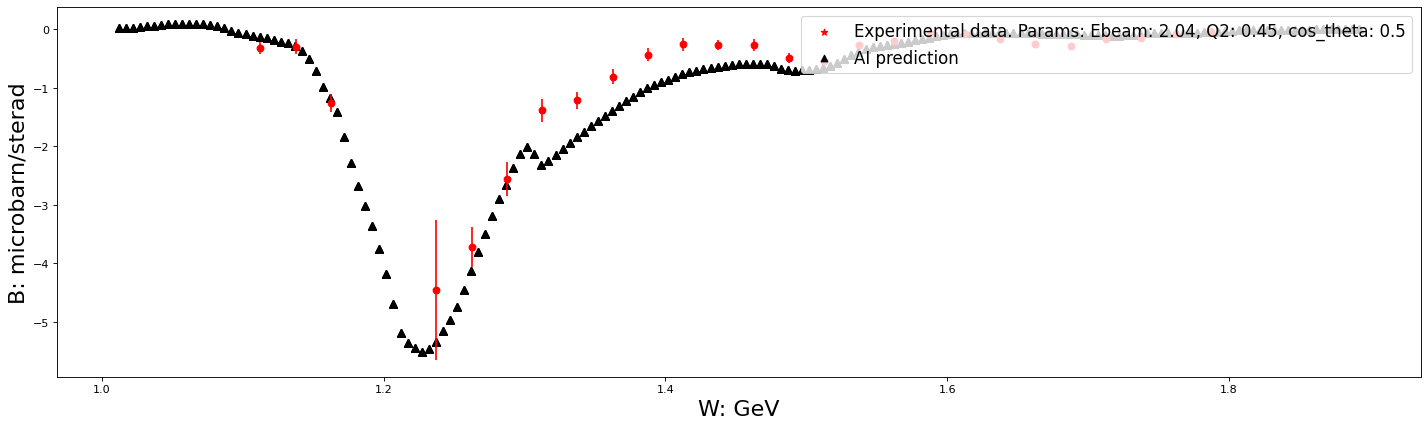

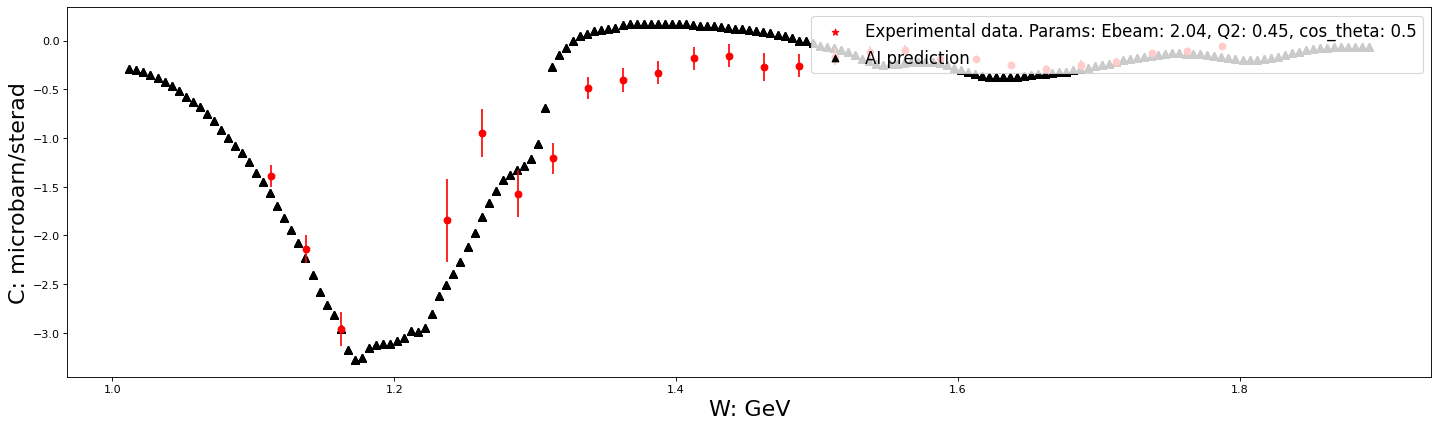

In [13]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [14]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-11 11:54:00,386 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:00,389 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:00,392 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:00,397 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 11:54:00,447 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-11 11:54:00,487 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 11:54:00,517 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 11:54:00,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:00,536 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:00,539 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:00,541 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 11:54:00,571 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:00,576 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:00,580 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:00,584 : DEBUG : STREAM b'IDAT' 131 38269
2024-12-11 11:54:00,612 : DEBUG : STREAM b'IHDR' 16 13
202

In [15]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-11 11:54:03,906 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:03,909 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:03,912 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:03,916 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 11:54:03,947 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:03,950 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:03,952 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:03,956 : DEBUG : STREAM b'IDAT' 131 38269
2024-12-11 11:54:03,976 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:03,979 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:03,981 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:03,983 : DEBUG : STREAM b'IDAT' 131 36586
2024-12-11 11:54:04,003 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:04,006 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 11:54:04,010 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 11:54:04,012 : DEBUG : STREAM b'IDAT' 131 36451
2024-12-11 11:54:04,032 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 11:54:04,036 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [16]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇▇███████████████████████████████████
train_rmse,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▇▃▂▂▁▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▇▃▂▃▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

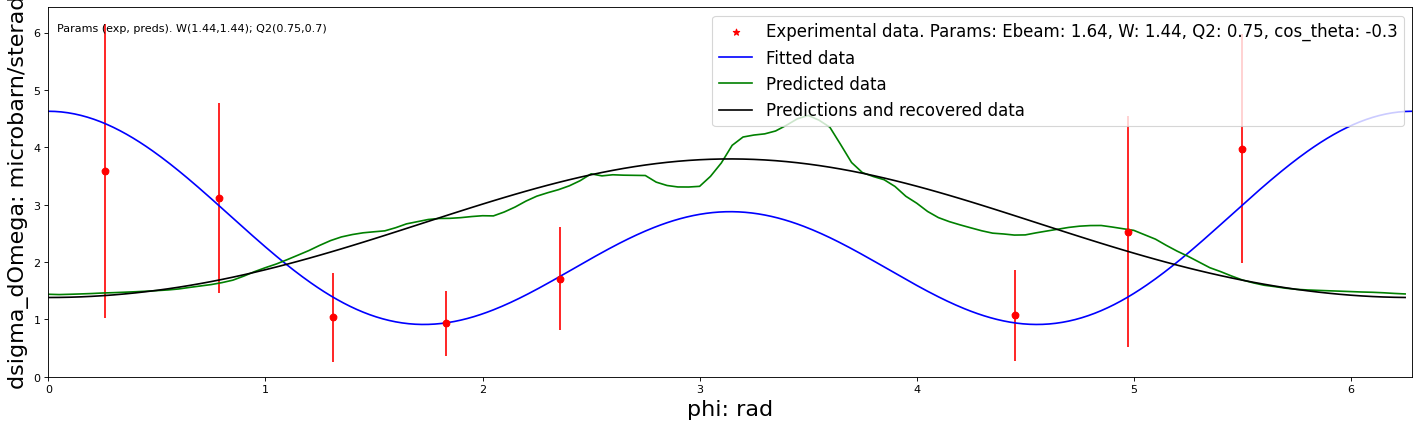

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


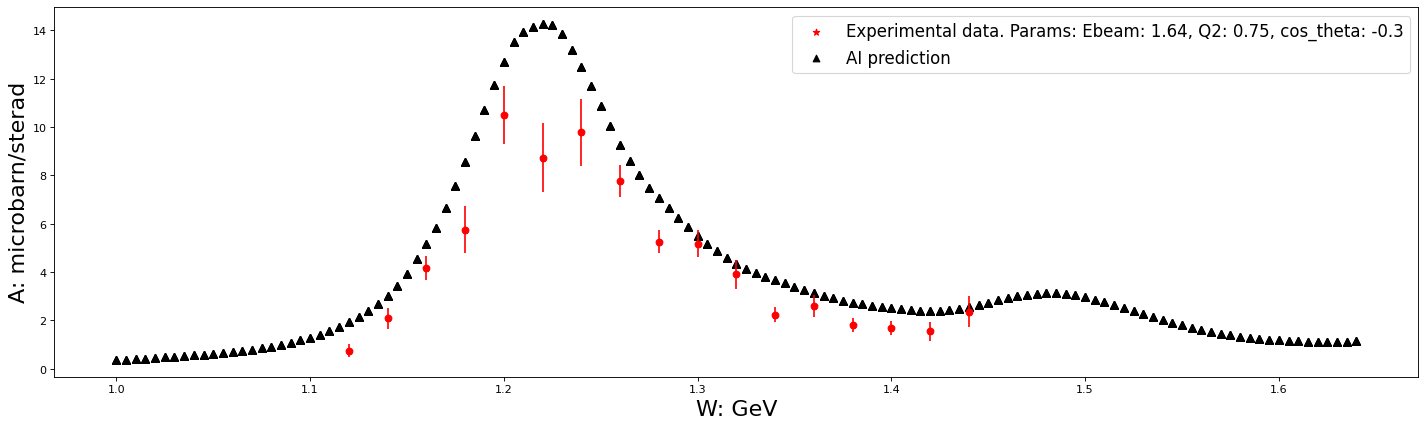

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


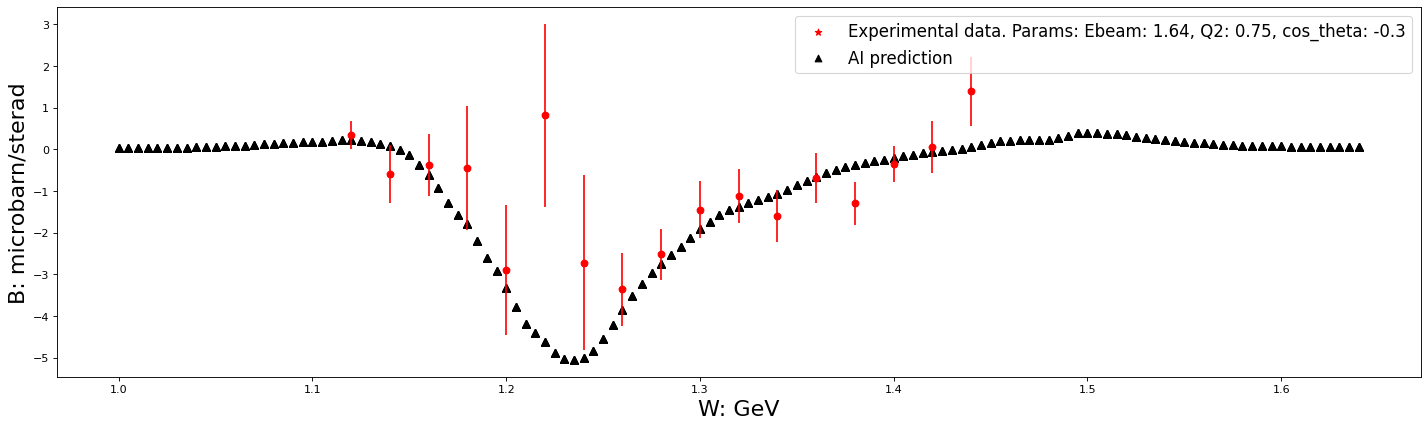

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


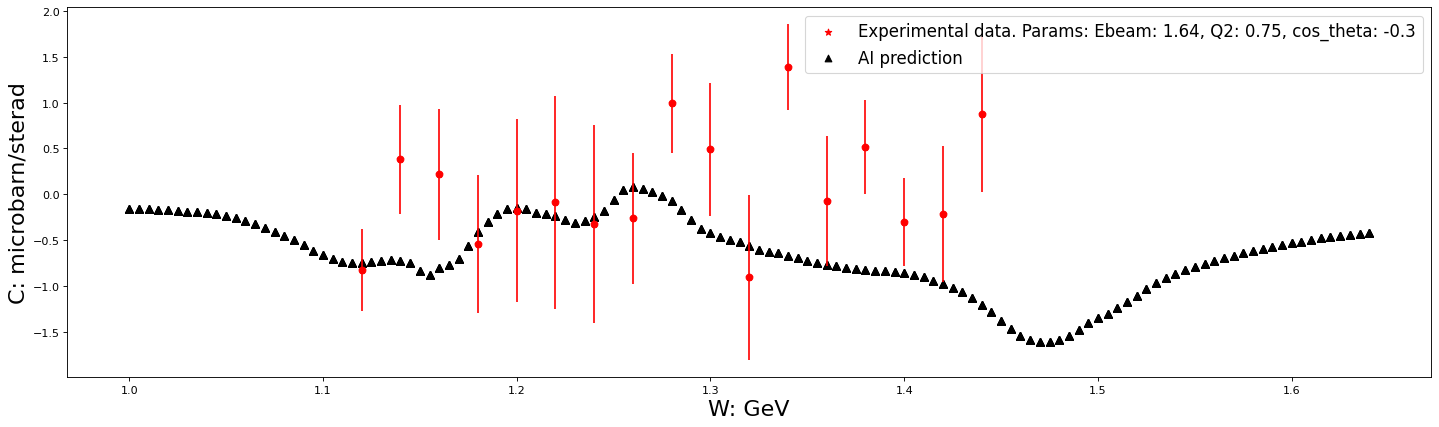

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


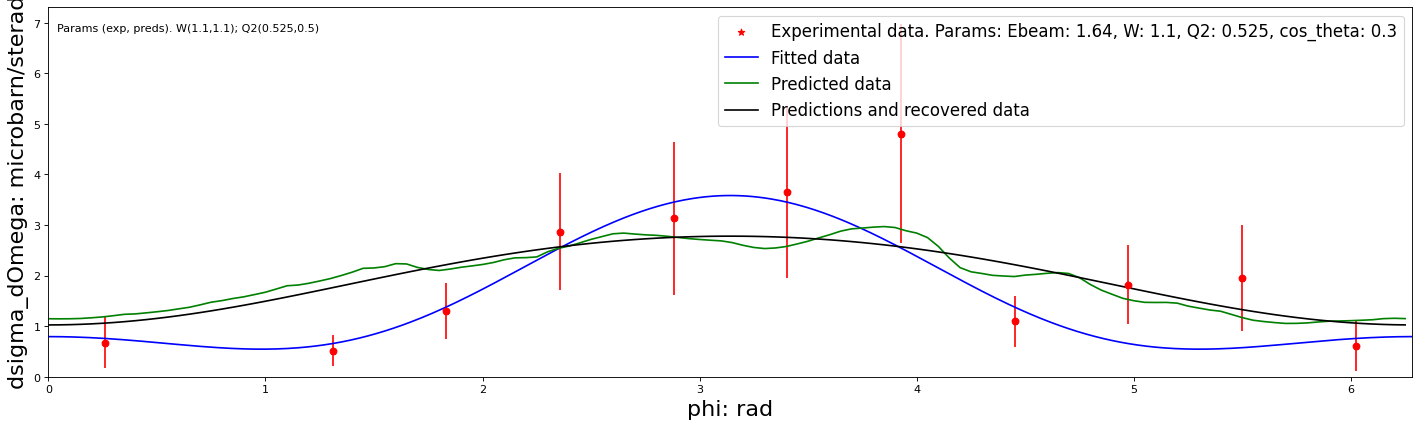

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


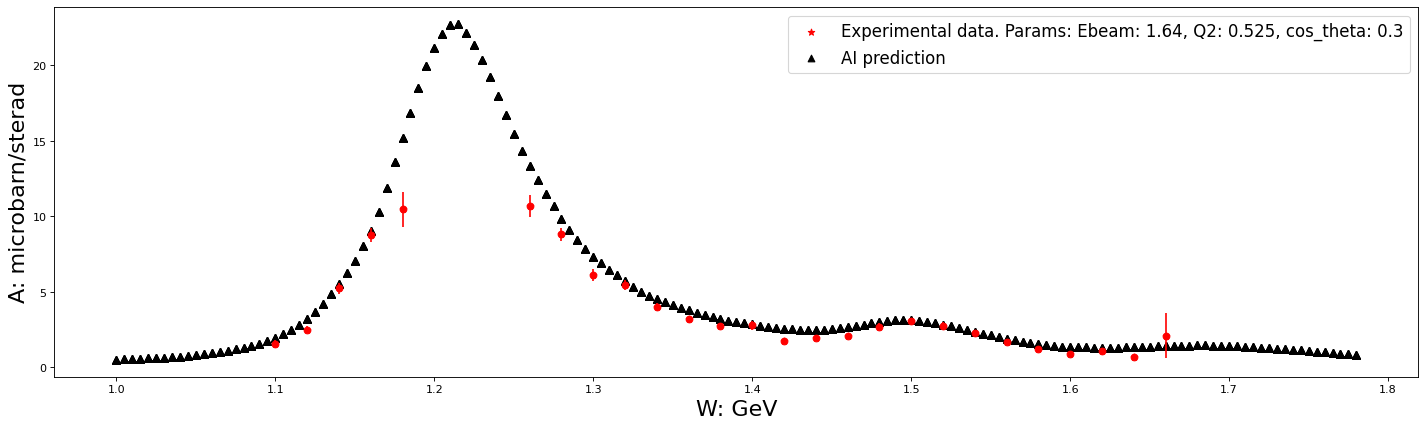

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


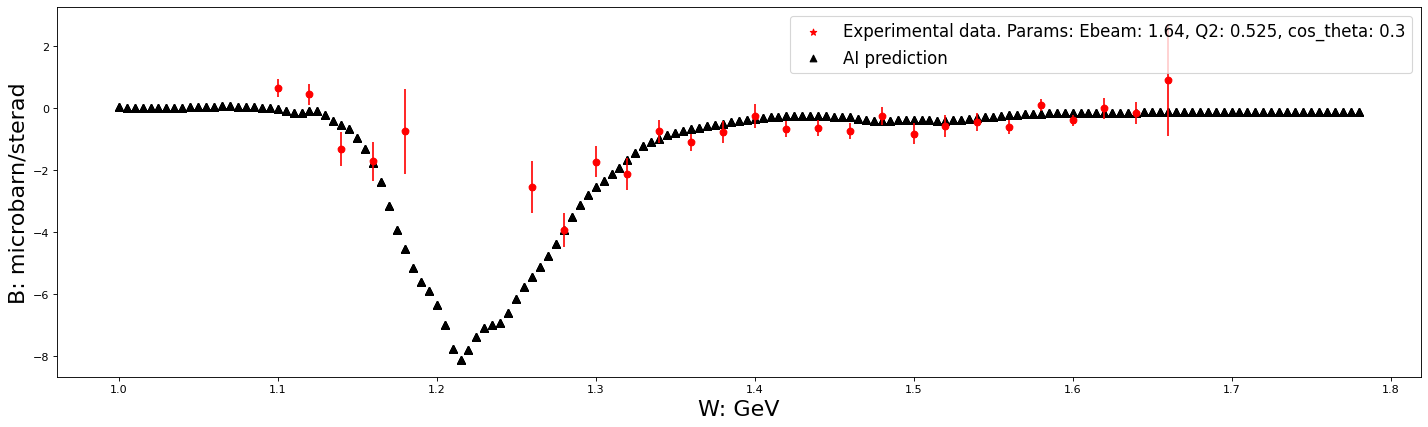

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


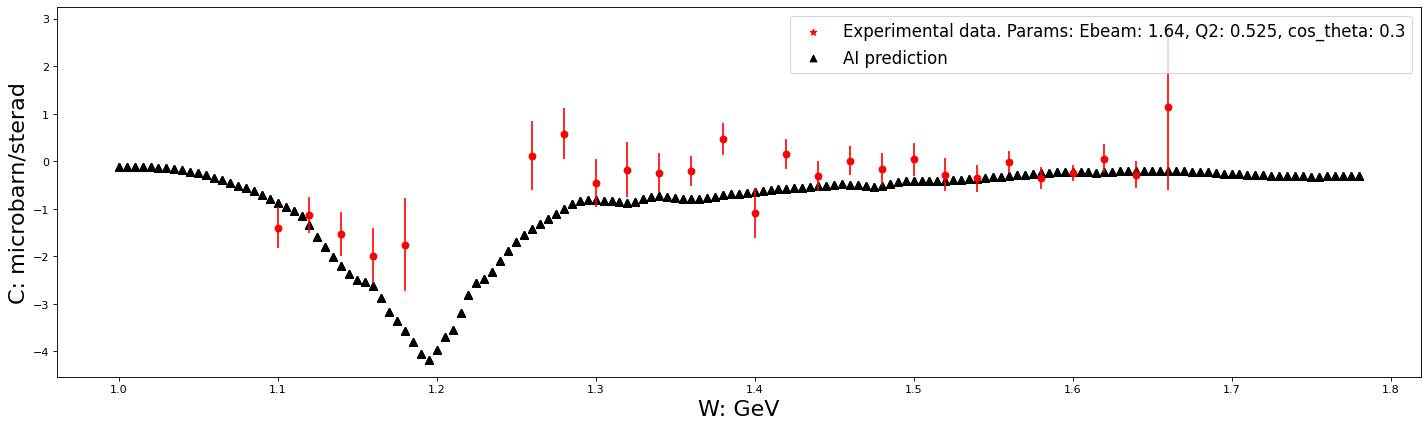

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


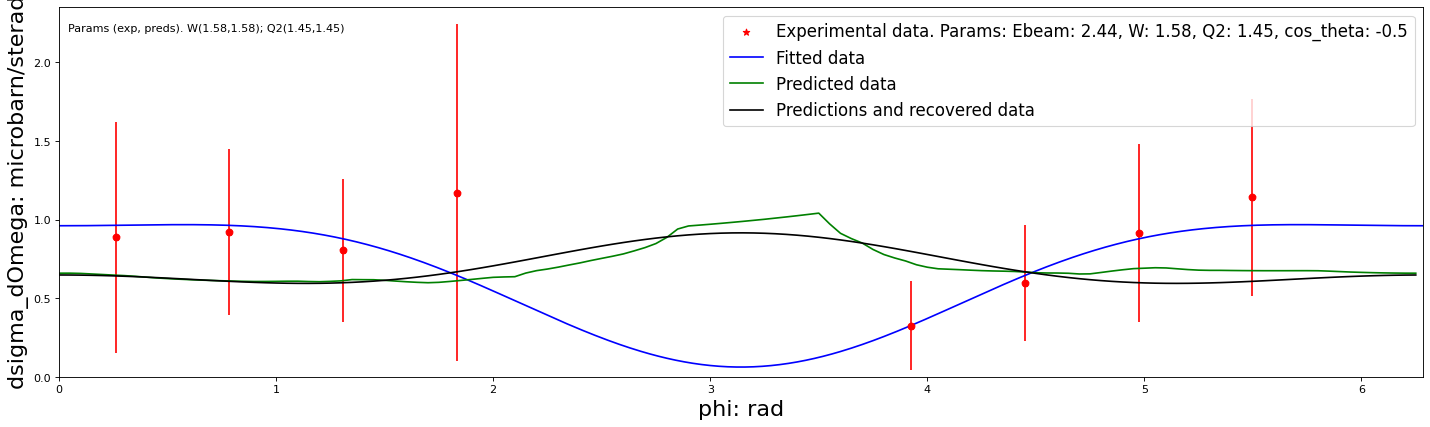

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


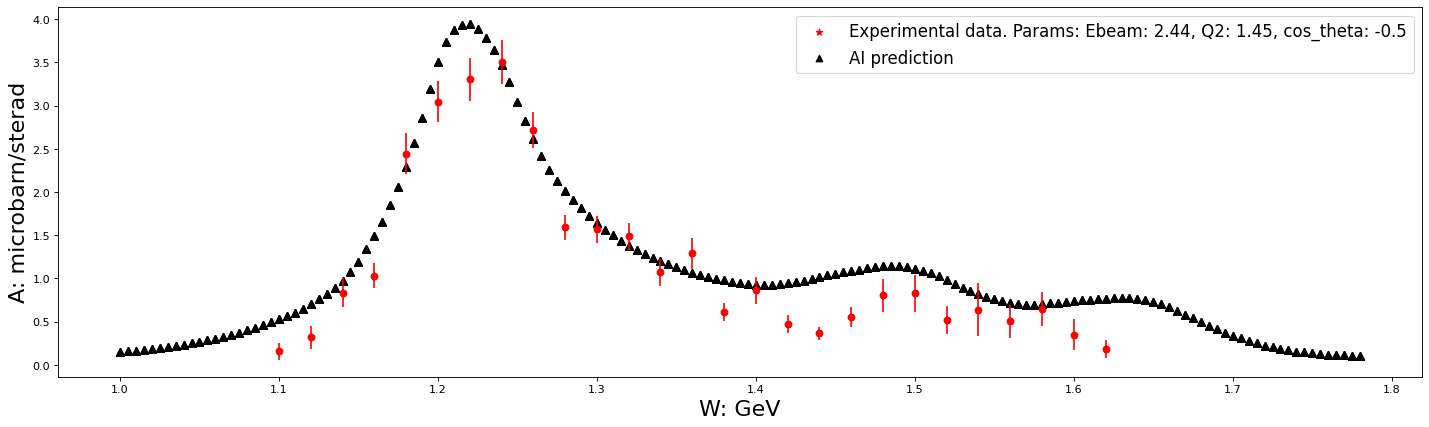

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


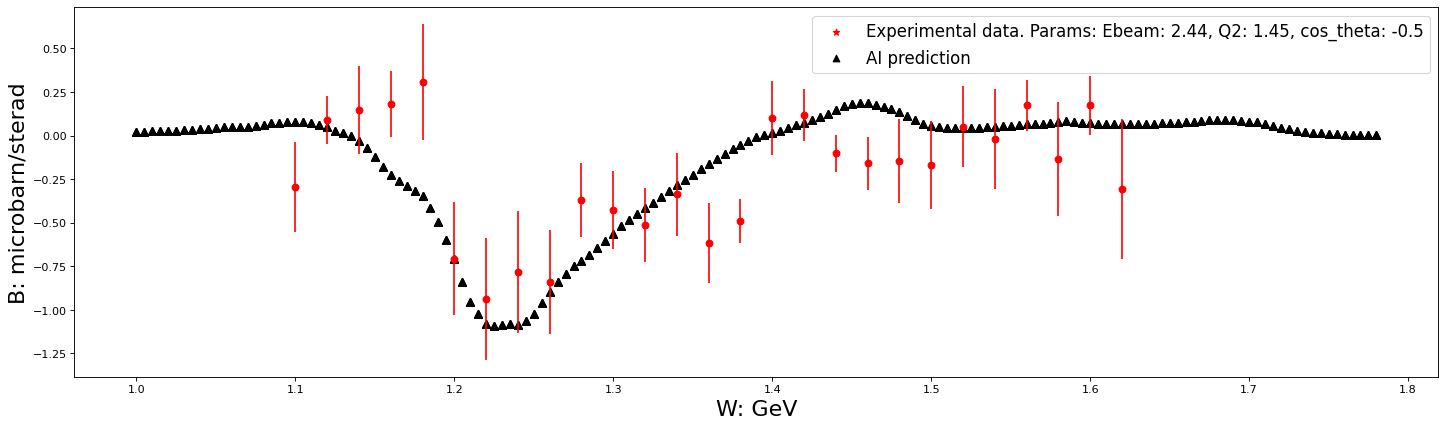

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


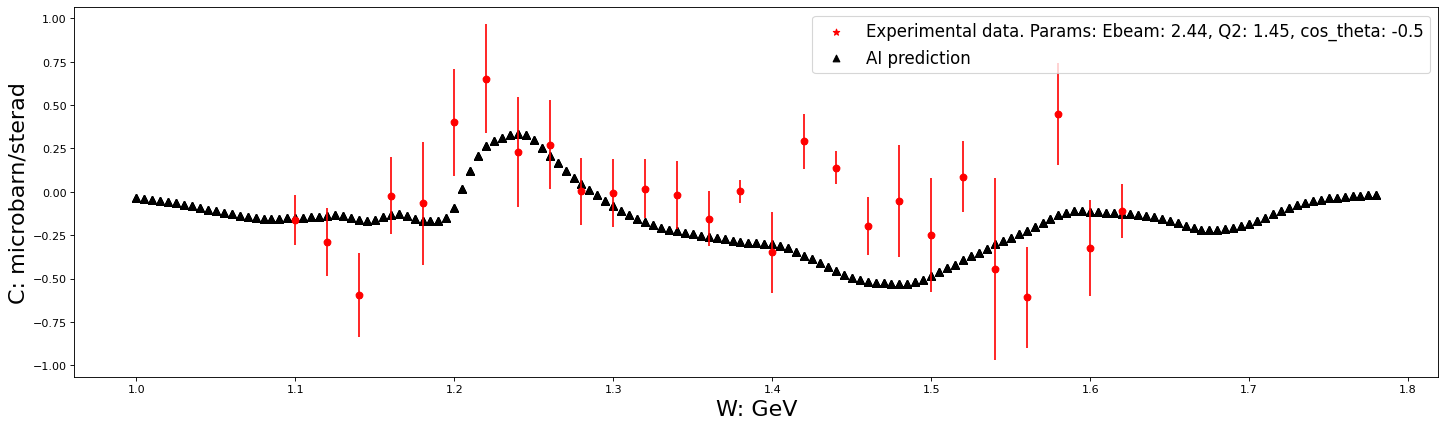

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


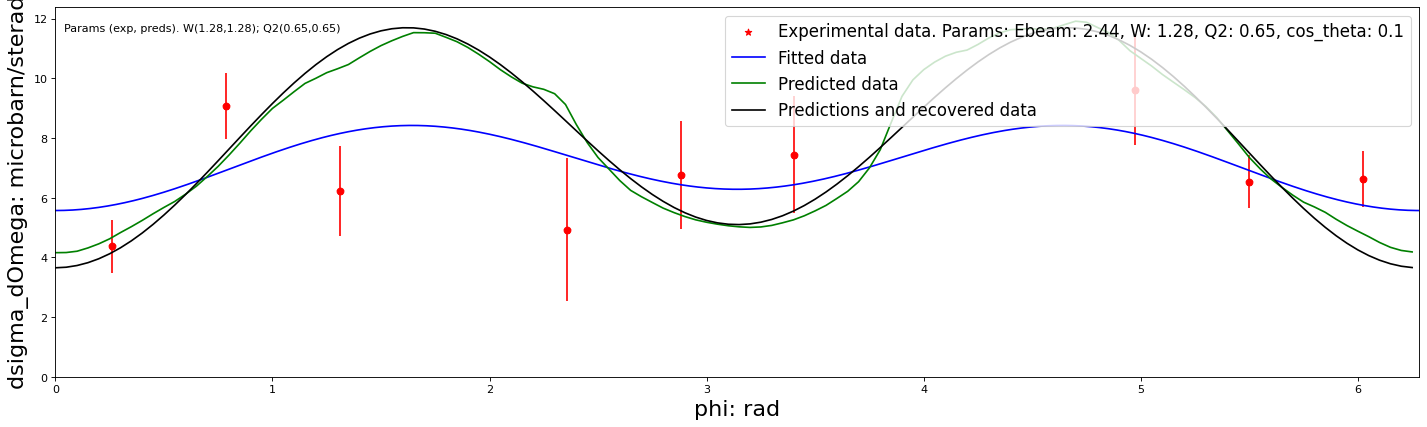

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


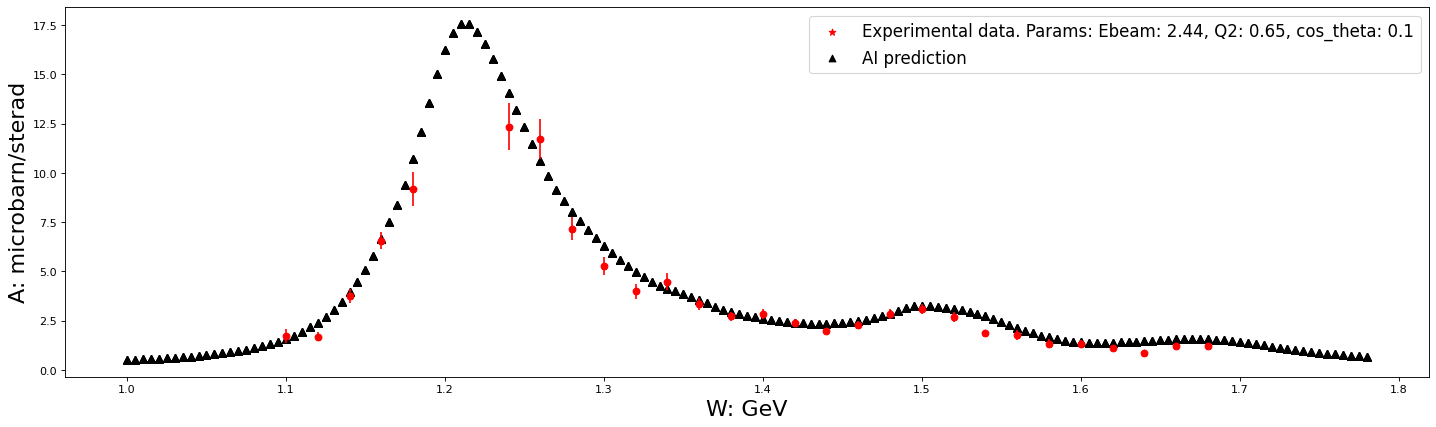

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


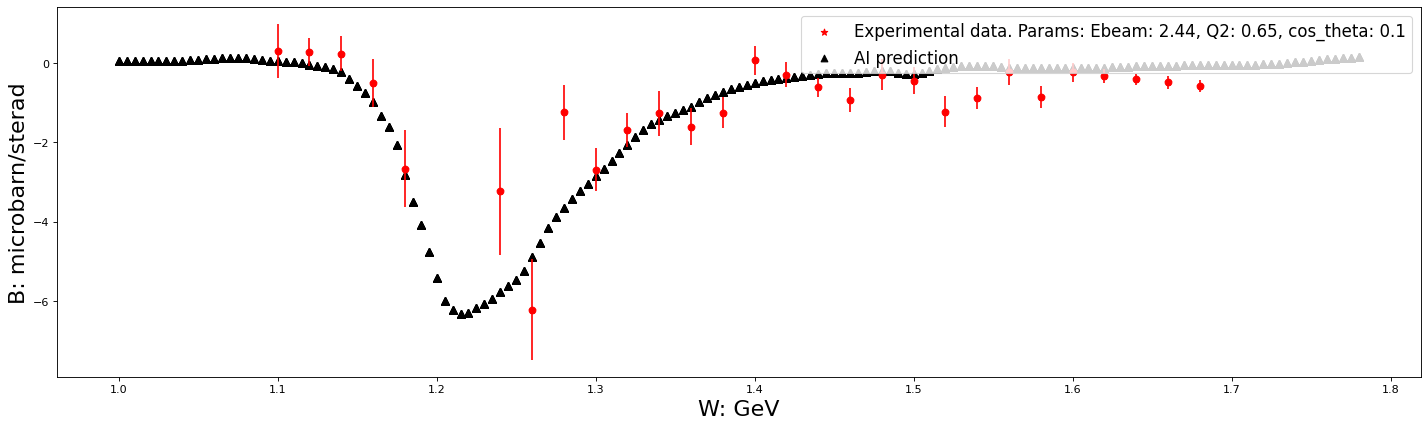

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


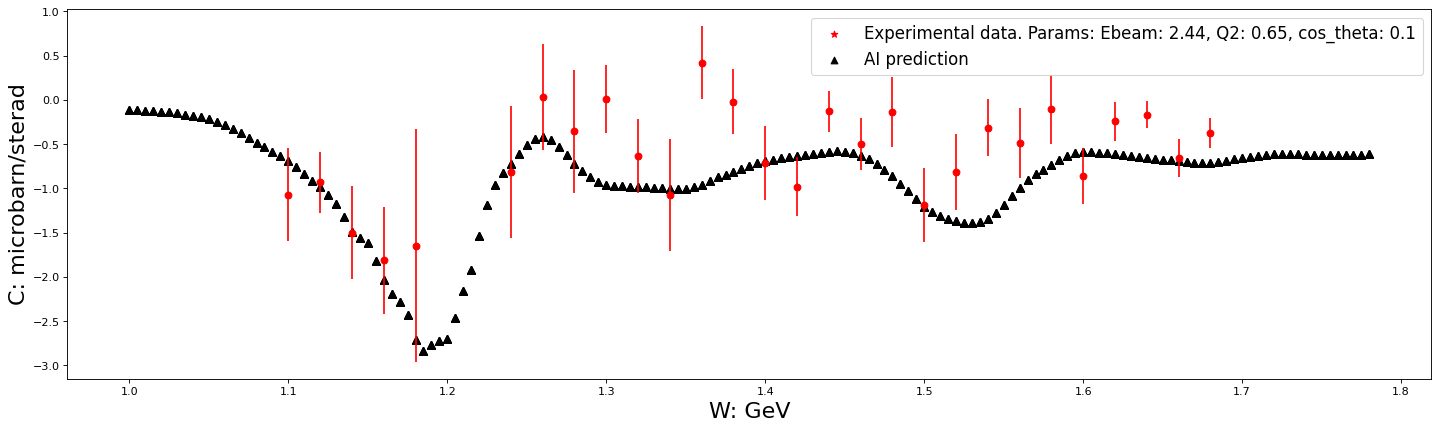

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False